In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, roc_curve, auc, roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import plotly.graph_objects as go
import pickle as pkl
from xgboost import XGBClassifier, plot_importance
import sys
from pathlib import Path
import yfinance as yf
import pandas as pd
from pathlib import Path
from datetime import date, timedelta
import scipy.stats as stats
pd.set_option('display.max_columns', None)

In [3]:

"""
REPO_ROOT = Path(__file__).resolve().parents[1]
DATA_DIR = REPO_ROOT / "raw_data" / "intraday"
DATA_DIR.mkdir(parents=True, exist_ok=True)

START_DATE = date.today() - timedelta(days=30)
def update_intraday_csv(ticker: str):
    
    #Fetches the most recent 1-minute intraday data for a given ticker,
    #and saves or appends it to 'intraday_{ticker}.csv'.
    
    filepath = DATA_DIR / f"intraday_{ticker}.csv"

    # If file exists, load it; else, create an empty DataFrame
    if filepath.exists():
        old_df = pd.read_csv(filepath, parse_dates=True, index_col='Datetime')
        last_date = old_df.index.max().date() if not old_df.empty else START_DATE
    else:
        old_df = pd.DataFrame()
        last_date = START_DATE

    start_date = last_date + timedelta(days=1)
    end_date = start_date + timedelta(days=8)

    print(f"Fetching {ticker} from {start_date} to {end_date}...")

    df = yf.Ticker(ticker).history(start=start_date, end=end_date, interval="1m")

    if df.empty:
        print(f"No new data returned for {ticker}.")
        if not old_df.empty:
            old_df.to_csv(filepath)
        return

    df.index.name = 'Datetime'

    if old_df.empty:
        df.to_csv(filepath)
    else:
        merged_df = pd.concat([old_df, df], sort=False)
        merged_df = merged_df[~merged_df.index.duplicated(keep='last')]  # drop duplicate indices
        merged_df.to_csv(filepath)

    print(f"Data for {ticker} saved to {filepath.name}.")

"""

'\nREPO_ROOT = Path(__file__).resolve().parents[1]\nDATA_DIR = REPO_ROOT / "raw_data" / "intraday"\nDATA_DIR.mkdir(parents=True, exist_ok=True)\n\nSTART_DATE = date.today() - timedelta(days=30)\ndef update_intraday_csv(ticker: str):\n\n    #Fetches the most recent 1-minute intraday data for a given ticker,\n    #and saves or appends it to \'intraday_{ticker}.csv\'.\n\n    filepath = DATA_DIR / f"intraday_{ticker}.csv"\n\n    # If file exists, load it; else, create an empty DataFrame\n    if filepath.exists():\n        old_df = pd.read_csv(filepath, parse_dates=True, index_col=\'Datetime\')\n        last_date = old_df.index.max().date() if not old_df.empty else START_DATE\n    else:\n        old_df = pd.DataFrame()\n        last_date = START_DATE\n\n    start_date = last_date + timedelta(days=1)\n    end_date = start_date + timedelta(days=8)\n\n    print(f"Fetching {ticker} from {start_date} to {end_date}...")\n\n    df = yf.Ticker(ticker).history(start=start_date, end=end_date, interva

In [3]:
REPO_ROOT = Path.cwd().parents[0]  # going back once from the current directory
SCRIPT_PATH = REPO_ROOT / "Scripts"
sys.path.append(str(SCRIPT_PATH))
from data import update_intraday_csv


update_intraday_csv("NVDA")
update_intraday_csv("INOD")
update_intraday_csv("MRVL")
update_intraday_csv("TSLA")

intraday_nvd = pd.read_csv('..\\raw_data\\intraday\\intraday_NVDA.csv')
intraday_mrvl = pd.read_csv('..\\raw_data\\intraday\\intraday_MRVL.csv')
intraday_inod = pd.read_csv('..\\raw_data\\intraday\\intraday_INOD.csv')
intraday_tsla = pd.read_csv('..\\raw_data\\intraday\\intraday_TSLA.csv')

intraday_nvd.head(1)

Fetching NVDA from 2025-08-02 to 2025-08-10...


$NVDA: possibly delisted; no price data found  (1m 2025-08-02 -> 2025-08-10)


No new data returned for NVDA.
Fetching INOD from 2025-08-02 to 2025-08-10...


$INOD: possibly delisted; no price data found  (1m 2025-08-02 -> 2025-08-10)


No new data returned for INOD.
Fetching MRVL from 2025-08-02 to 2025-08-10...


$MRVL: possibly delisted; no price data found  (1m 2025-08-02 -> 2025-08-10)


No new data returned for MRVL.
Fetching TSLA from 2025-08-02 to 2025-08-10...


$TSLA: possibly delisted; no price data found  (1m 2025-08-02 -> 2025-08-10)


No new data returned for TSLA.


,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2025-06-23 09:30:00-04:00,143.429993,143.429993,143.429993,143.429993,9728623,0.0,0.0


In [204]:
def cleanup(df):
    """
    Convert 'Datetime' to proper datetime format and extract temporal features.
    Optimizes column types for efficient time-based analysis.
    """
    df['Datetime'] = pd.to_datetime(df['Datetime'], dayfirst=False)

    # Extract temporal components
    df['Date'] = df['Datetime'].dt.date
    df['Time'] = df['Datetime'].dt.time
    df['Hour'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute
    df['Weekday'] = df['Datetime'].dt.day_name()

    # Drop unused or redundant columns
    df = df.drop(columns=['Datetime', 'Dividends', 'Stock Splits'], errors='ignore')

    # Optimize types
    df['Date'] = pd.to_datetime(df['Date'])  # promote from object to datetime64
    df['Weekday'] = pd.Categorical(
        df['Weekday'],
        categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
        ordered=True
    )

    return df

In [205]:
intraday_nvd = cleanup(intraday_nvd)
intraday_inod = cleanup(intraday_inod)
intraday_mrvl = cleanup(intraday_mrvl)

In [206]:
def feature_selection(df: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    """
    Enhances a stock DataFrame with derived analytical features:
    - Open-Close deltas (absolute and percent)
    - High-Low spreads (absolute and percent from Open/Close)
    - Volume deviation from average (absolute and percent)
    - Stock identifier label
    - Ordered columns
    """
    df = df.copy()  # avoid modifying original

    # Open-Close dynamics
    df['open_close_diff'] = df['Open'] - df['Close']
    df['open_close_diff_pct'] = (df['Close'] - df['Open']) / df['Open']

    # High-Low range
    df['high_low_diff'] = df['High'] - df['Low']
    df['high_low_diff_pct_frm_close'] = df['high_low_diff'] / (df['Close'] + 1e-6)
    df['high_low_diff_pct_frm_close'] = df['high_low_diff'] / df['Close']

    # Volume activity relative to average
    volume_avg = df['Volume'].mean()
    df['volume_diff_frm_avg'] = df['Volume'] - volume_avg
    df['volume_diff_frm_avg_pct'] = df['volume_diff_frm_avg'] / volume_avg

    # Tag the stock
    df['stock'] = stock_name

    # Reorder columns for coherence
    desired_order = [
        'Date',
        'Open', 'Close', 'open_close_diff', 'open_close_diff_pct',
        'High', 'Low', 'high_low_diff', 'high_low_diff_pct_frm_open', 'high_low_diff_pct_frm_close',
        'Volume', 'volume_diff_frm_avg', 'volume_diff_frm_avg_pct',
        'stock'
    ]
    
    # Gracefully reorder only if all desired columns exist
    existing_order = [col for col in desired_order if col in df.columns]
    df = df[existing_order + [col for col in df.columns if col not in existing_order]]
    def prefix_columns(df):
        stock_code = df['stock'].iloc[0] if 'stock' in df.columns else 'Unknown'
        df = df.copy()
        df = df.drop(columns=['stock'])  # remove redundant stock column
        df.columns = [f"{stock_code}_{col}" if col != 'Date' else 'Date' for col in df.columns]
        return df

    df = prefix_columns(df)
    return df

In [207]:
intraday_nvd = feature_selection(intraday_nvd, 'NVDA')
intraday_inod = feature_selection(intraday_inod, 'INOD')
intraday_mrvl = feature_selection(intraday_mrvl, 'MRVL')

In [208]:
def standardize_time_columns(df, ticker):
    return df.rename(columns={
        f'{ticker}_Hour': 'Hour',
        f'{ticker}_Minute': 'Minute',
        f'{ticker}_Time': 'Time',
        f'{ticker}_Weekday': 'Weekday'
    })

# Apply to each DataFrame
intraday_nvd = standardize_time_columns(intraday_nvd, 'NVDA')
intraday_inod = standardize_time_columns(intraday_inod, 'INOD')
intraday_mrvl = standardize_time_columns(intraday_mrvl, 'MRVL')

In [209]:
intraday_combined_df = (
    intraday_nvd
    .merge(intraday_inod, on=['Date', 'Time', 'Hour', 'Minute', 'Weekday'], how='outer')
    .merge(intraday_mrvl, on=['Date', 'Time', 'Hour', 'Minute', 'Weekday'], how='outer')
)

In [210]:
desired_order = [
    'Date', 'Time', 'Hour', 'Minute', 'Weekday',

    # NVDA
    'NVDA_Open', 'NVDA_Close', 'NVDA_open_close_diff', 'NVDA_open_close_diff_pct',
    'NVDA_High', 'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
    'NVDA_Volume', 'NVDA_volume_diff_frm_avg', 'NVDA_volume_diff_frm_avg_pct',

    # INOD
    'INOD_Open', 'INOD_Close', 'INOD_open_close_diff', 'INOD_open_close_diff_pct',
    'INOD_High', 'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
    'INOD_Volume', 'INOD_volume_diff_frm_avg', 'INOD_volume_diff_frm_avg_pct',

    # MRVL
    'MRVL_Open', 'MRVL_Close', 'MRVL_open_close_diff', 'MRVL_open_close_diff_pct',
    'MRVL_High', 'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
    'MRVL_Volume', 'MRVL_volume_diff_frm_avg', 'MRVL_volume_diff_frm_avg_pct'
]

existing_order = [col for col in desired_order if col in intraday_combined_df.columns]
intraday_combined_df = intraday_combined_df[existing_order + [col for col in intraday_combined_df.columns if col not in existing_order]]

intraday_combined_df.isna().sum()

intraday_combined_df[intraday_combined_df.isna().any(axis=1)]

,Date,Time,Hour,Minute,Weekday,NVDA_Open,NVDA_Close,NVDA_open_close_diff,NVDA_open_close_diff_pct,NVDA_High,NVDA_Low,NVDA_high_low_diff,NVDA_high_low_diff_pct_frm_close,NVDA_Volume,NVDA_volume_diff_frm_avg,NVDA_volume_diff_frm_avg_pct,INOD_Open,INOD_Close,INOD_open_close_diff,INOD_open_close_diff_pct,INOD_High,INOD_Low,INOD_high_low_diff,INOD_high_low_diff_pct_frm_close,INOD_Volume,INOD_volume_diff_frm_avg,INOD_volume_diff_frm_avg_pct,MRVL_Open,MRVL_Close,MRVL_open_close_diff,MRVL_open_close_diff_pct,MRVL_High,MRVL_Low,MRVL_high_low_diff,MRVL_high_low_diff_pct_frm_close,MRVL_Volume,MRVL_volume_diff_frm_avg,MRVL_volume_diff_frm_avg_pct
83,2025-06-23,10:53:00,10,53,Monday,143.729904,143.755005,-0.025101,0.000175,143.759995,143.660004,0.099991,0.000696,182462.0,-239866.855412,-0.567962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.730003,71.709999,0.020004,-0.000279,71.735001,71.669998,0.065002,0.000906,44034.0,-1520.542051,-0.033378
84,2025-06-23,10:54:00,10,54,Monday,143.750107,143.789993,-0.039886,0.000277,143.835007,143.740005,0.095001,0.000661,326498.0,-95830.855412,-0.226911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.650002,71.480103,0.169899,-0.002371,71.650002,71.464996,0.185005,0.002588,62594.0,17039.457949,0.374045
102,2025-06-23,11:17:00,11,17,Monday,144.054993,143.960007,0.094986,-0.000659,144.059998,143.955002,0.104996,0.000729,114500.0,-307828.855412,-0.728884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.400398,71.330002,0.070396,-0.000986,71.400398,71.330002,0.070396,0.000987,4564.0,-40990.542051,-0.899812
103,2025-06-23,11:18:00,11,18,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.930000,47.930000,0.000000,0.000000,47.930000,47.930000,0.000000,0.000000,4707.0,-1457.366099,-0.236418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,2025-06-23,12:54:00,12,54,Monday,143.330002,143.500000,-0.169998,0.001186,143.520004,143.330002,0.190002,0.001324,237125.0,-185203.855412,-0.438530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.404999,70.445000,-0.040001,0.000568,70.470001,70.404999,0.065002,0.000923,14769.0,-30785.542051,-0.675795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7243,2025-07-21,10:22:00,10,22,Monday,172.759995,172.690002,0.069992,-0.000405,172.768402,172.649994,0.118408,0.000686,265284.0,-157044.855412,-0.371854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.150002,73.099998,0.050003,-0.000684,73.169998,73.099998,0.070000,0.000958,29862.0,-15692.542051,-0.344478
7439,2025-07-21,13:38:00,13,38,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.869999,46.869999,0.000000,0.000000,46.869999,46.869999,0.000000,0.000000,6354.0,189.633901,0.030763,73.044998,73.040001,0.004997,-0.000068,73.059700,73.035004,0.024696,0.000338,23654.0,-21900.542051,-0.480754
7587,2025-07-22,09:36:00,9,36,Tuesday,168.800003,168.970398,-0.170395,0.001009,169.039993,168.449997,0.589996,0.003492,1415981.0,993652.144588,2.352792,46.900002,46.867100,0.032902,-0.000702,46.978001,46.855000,0.123001,0.002624,3467.0,-2697.366099,-0.437574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7588,2025-07-22,09:37:00,9,37,Tuesday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.849998,46.820000,0.029999,-0.000640,46.849998,46.820000,0.029999,0.000641,2229.0,-3935.366099,-0.638406,72.870003,72.919998,-0.049995,0.000686,72.919998,72.858704,0.061295,0.000841,91447.0,45892.457949,1.007418


In [211]:
intraday_combined_df.loc[[102,103, 104]]


,Date,Time,Hour,Minute,Weekday,NVDA_Open,NVDA_Close,NVDA_open_close_diff,NVDA_open_close_diff_pct,NVDA_High,NVDA_Low,NVDA_high_low_diff,NVDA_high_low_diff_pct_frm_close,NVDA_Volume,NVDA_volume_diff_frm_avg,NVDA_volume_diff_frm_avg_pct,INOD_Open,INOD_Close,INOD_open_close_diff,INOD_open_close_diff_pct,INOD_High,INOD_Low,INOD_high_low_diff,INOD_high_low_diff_pct_frm_close,INOD_Volume,INOD_volume_diff_frm_avg,INOD_volume_diff_frm_avg_pct,MRVL_Open,MRVL_Close,MRVL_open_close_diff,MRVL_open_close_diff_pct,MRVL_High,MRVL_Low,MRVL_high_low_diff,MRVL_high_low_diff_pct_frm_close,MRVL_Volume,MRVL_volume_diff_frm_avg,MRVL_volume_diff_frm_avg_pct
102,2025-06-23,11:17:00,11,17,Monday,144.054993,143.960007,0.094986,-0.000659,144.059998,143.955002,0.104996,0.000729,114500.0,-307828.855412,-0.728884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.400398,71.330002,0.070396,-0.000986,71.400398,71.330002,0.070396,0.000987,4564.0,-40990.542051,-0.899812
103,2025-06-23,11:18:00,11,18,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.930000,47.930000,0.00,0.000000,47.930000,47.930000,0.00,0.00000,4707.0,-1457.366099,-0.236418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
104,2025-06-23,11:19:00,11,19,Monday,144.154205,144.205002,-0.050797,0.000352,144.210007,144.149994,0.060013,0.000416,675978.0,253649.144588,0.600596,47.950001,47.860001,0.09,-0.001877,47.950001,47.860001,0.09,0.00188,1144.0,-5020.366099,-0.814417,71.360001,71.379997,-0.019997,0.000280,71.389999,71.360001,0.029999,0.000420,102189.0,56634.457949,1.243223


It is to be decided that across all instances of NaN, these columns will be dropped. Since the 1 minute ticker basis does offer an enough inspection into the granularity of the stocks' behavior.

In [212]:
intraday_combined_df = intraday_combined_df.dropna(axis=0)

#intraday_combined_df.isna().sum()
intraday_combined_df.shape

(7414, 38)

In [213]:
#Further data preparation steps:
# Classification & Probabilistic Conditioning
intraday_combined_df['INOD_up'] = (intraday_combined_df['INOD_open_close_diff_pct'] > 0).astype(int)
intraday_combined_df['NVDA_up'] = (intraday_combined_df['NVDA_open_close_diff_pct'] > 0).astype(int)
intraday_combined_df['MRVL_up'] = (intraday_combined_df['MRVL_open_close_diff_pct'] > 0).astype(int)

threshold = 50  
intraday_combined_df['NVDA_volume_spike'] = (
    intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] > threshold
).astype(int)

In [214]:
from datetime import time
intraday_combined_df['Time'] = pd.to_datetime(intraday_combined_df['Time'], format='%H:%M:%S').dt.time



def classify_rth_segment(t):
    if time(9, 30) <= t < time(10, 0):
        return 'Opening Bell'
    elif time(10, 0) <= t < time(11, 30):
        return 'Morning Trend'
    elif time(11, 30) <= t < time(14, 0):
        return 'Midday Lull'
    elif time(14, 0) <= t < time(15, 30):
        return 'Afternoon Run'
    elif time(15, 30) <= t < time(16, 0):
        return 'Closing Rush'
    else:
        return None  # Outside RTH
    
intraday_combined_df['rth_segment'] = intraday_combined_df['Time'].apply(classify_rth_segment)

intraday_combined_df = intraday_combined_df.sort_values(by=['Date','Time'], ascending=False)

Simple A/B testing

In [215]:
threshold = intraday_combined_df['NVDA_volume_diff_frm_avg_pct'].median()
group_high = intraday_combined_df[intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
group_low = intraday_combined_df[intraday_combined_df['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

from datetime import date

date = pd.to_datetime('2025-07-02')

timeframe_start = pd.to_datetime('2025-07-02')
timeframe_end = timeframe_start + pd.Timedelta(days=5)

d = intraday_combined_df[intraday_combined_df['Date'] == date]

tf = intraday_combined_df[(intraday_combined_df['Date'] >= timeframe_start) & (intraday_combined_df['Date'] <= timeframe_end)]

d_threshold = d['NVDA_volume_diff_frm_avg_pct'].median()
d_group_high = d[d['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
d_group_low = d[d['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

tf_threshold = tf['NVDA_volume_diff_frm_avg_pct'].median()
tf_group_high = tf[tf['NVDA_volume_diff_frm_avg_pct'] > threshold]['INOD_open_close_diff_pct']
tf_group_low = tf[tf['NVDA_volume_diff_frm_avg_pct'] <= threshold]['INOD_open_close_diff_pct']

In [216]:
t_test, p_value = ttest_ind(
    group_high, group_low, equal_var=False)

d_t_test,d_p_value = ttest_ind(
    d_group_high, d_group_low, equal_var=False)

tf_t_test, tf_p_value = ttest_ind(
    tf_group_high, tf_group_low, equal_var=False)

print(f'Mean High: {group_high.mean():.4f}')
print(f'Mean Low: {group_low.mean():.4f}')
print(f'T-test: {t_test:.4f}, P-value: {p_value:.4f}')

print(f'Mean High: {d_group_high.mean():.4f}')
print(f'Mean Low: {d_group_low.mean():.4f}')
print(f'T-test: {d_t_test:.4f}, P-value: {d_p_value:.4f}')

print(f'Mean High: {tf_group_high.mean():.4f}')
print(f'Mean Low: {tf_group_low.mean():.4f}')
print(f'T-test: {tf_t_test:.4f}, P-value: {tf_p_value:.4f}')


Mean High: -0.0000
Mean Low: 0.0000
T-test: -0.7584, P-value: 0.4483
Mean High: 0.0002
Mean Low: 0.0001
T-test: 0.4974, P-value: 0.6194
Mean High: 0.0001
Mean Low: 0.0001
T-test: 0.2678, P-value: 0.7889


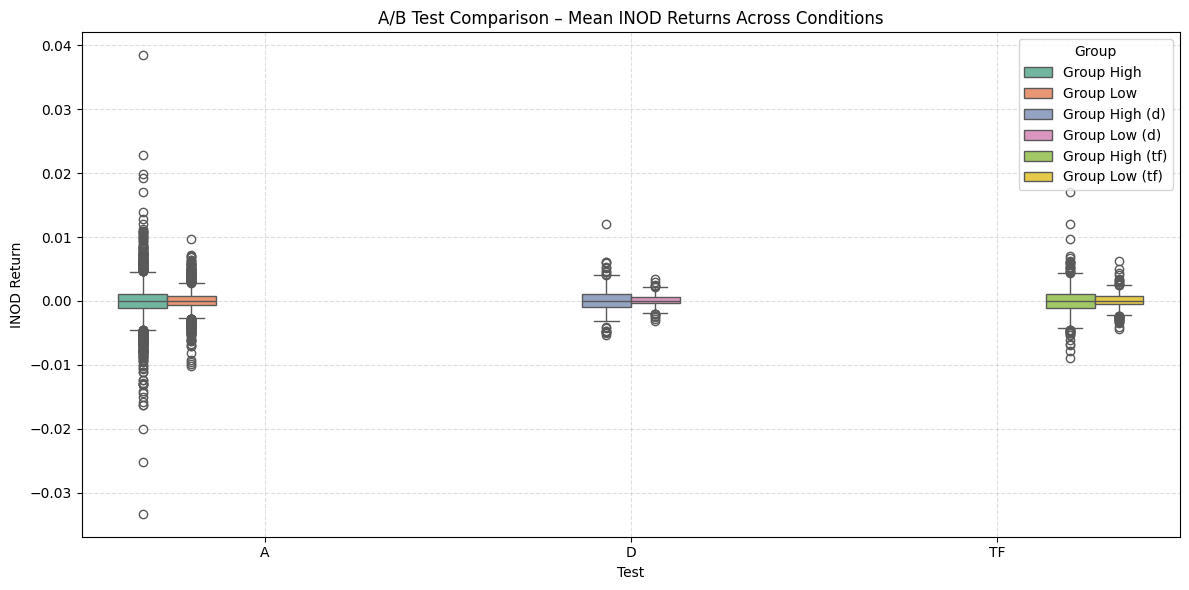

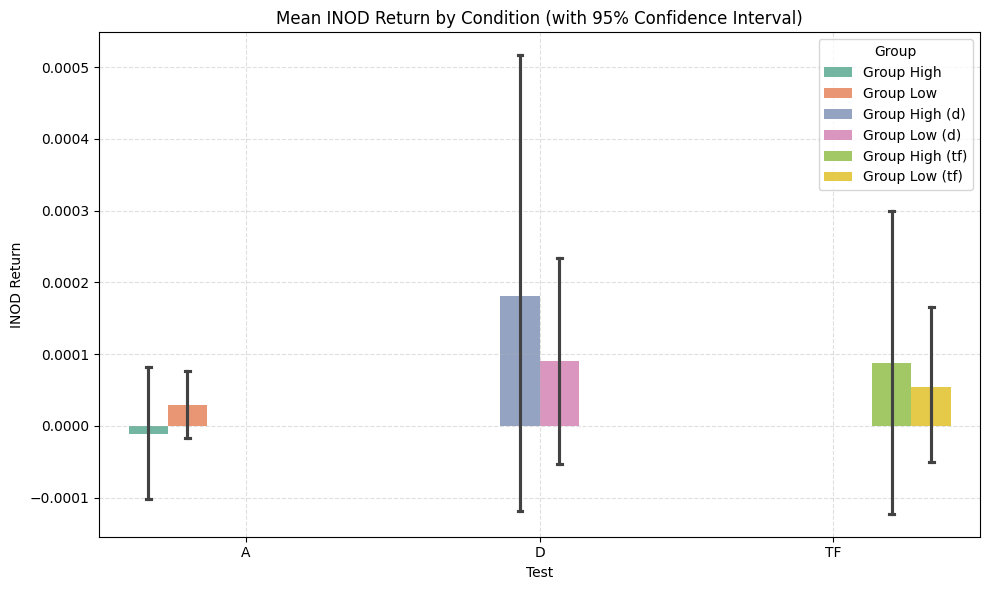

In [217]:
plot_df = pd.DataFrame({
    'INOD Return': group_high.tolist() + group_low.tolist() +
                   d_group_high.tolist() + d_group_low.tolist() +
                   tf_group_high.tolist() + tf_group_low.tolist(),
    'Group': (['Group High'] * len(group_high) + ['Group Low'] * len(group_low) +
              ['Group High (d)'] * len(d_group_high) + ['Group Low (d)'] * len(d_group_low) +
              ['Group High (tf)'] * len(tf_group_high) + ['Group Low (tf)'] * len(tf_group_low)),
    'Test': (['A'] * (len(group_high) + len(group_low)) +
             ['D'] * (len(d_group_high) + len(d_group_low)) +
             ['TF'] * (len(tf_group_high) + len(tf_group_low)))
})

plt.figure(figsize=(12, 6))
sns.boxplot(x='Test', y='INOD Return', hue='Group', data=plot_df, palette='Set2')
plt.title('A/B Test Comparison – Mean INOD Returns Across Conditions')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Test', y='INOD Return', hue='Group', data=plot_df, errorbar=('ci', 95), palette='Set2', capsize=0.1)
plt.title('Mean INOD Return by Condition (with 95% Confidence Interval)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

It can be observed with the selection of a Single date, the whole Timeframe, and a selected Timeframe that NVDA's Volume has minimal effects on INOD return by the minutes.

=> We do not accept the notion that INOD changes throughout the day is affected by NVDA's volume. 

Simple Regression:


--- Model 1: INOD ~ NVDA_return ---
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.038
Model:                                  OLS   Adj. R-squared:                  0.038
Method:                       Least Squares   F-statistic:                     295.4
Date:                      Wed, 23 Jul 2025   Prob (F-statistic):           6.07e-65
Time:                              09:12:40   Log-Likelihood:                 34709.
No. Observations:                      7414   AIC:                        -6.941e+04
Df Residuals:                          7412   BIC:                        -6.940e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------

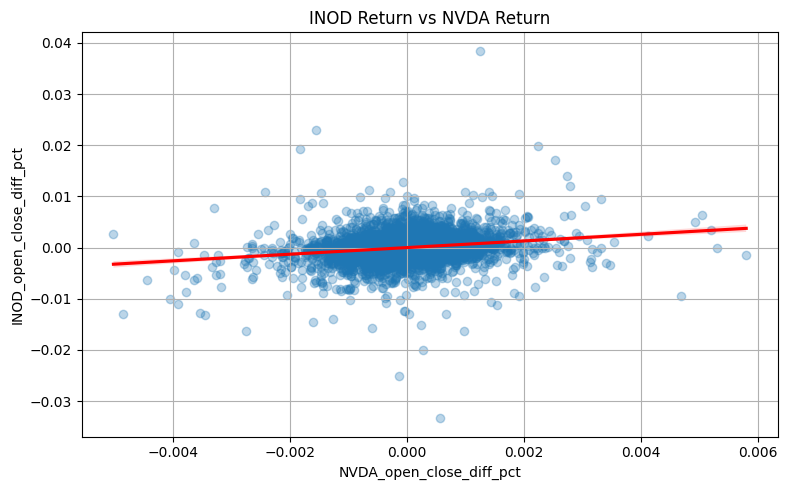

In [218]:
# Regression 1: INOD ~ NVDA return
X1 = sm.add_constant(intraday_combined_df['NVDA_open_close_diff_pct'])
y1 = intraday_combined_df['INOD_open_close_diff_pct']

model1 = sm.OLS(y1, X1).fit()
print("\n--- Model 1: INOD ~ NVDA_return ---")
print(model1.summary())

y_pred = model1.predict(X1)
residuals = y1 - y_pred

plt.figure(figsize=(8, 5))
sns.regplot(
    x='NVDA_open_close_diff_pct',
    y='INOD_open_close_diff_pct',
    data=intraday_combined_df,
    line_kws={"color": "red"},
    scatter_kws={"alpha": 0.3}
)
plt.title('INOD Return vs NVDA Return')
plt.xlabel('NVDA_open_close_diff_pct')
plt.ylabel('INOD_open_close_diff_pct')
plt.grid(True)
plt.tight_layout()
plt.show()


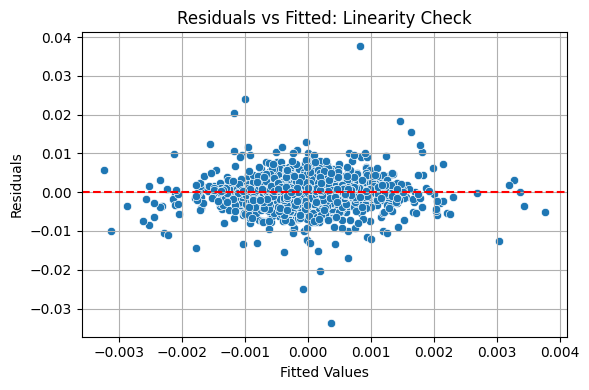

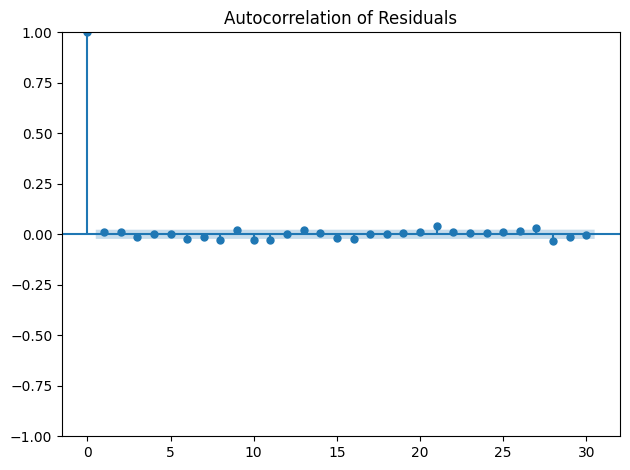

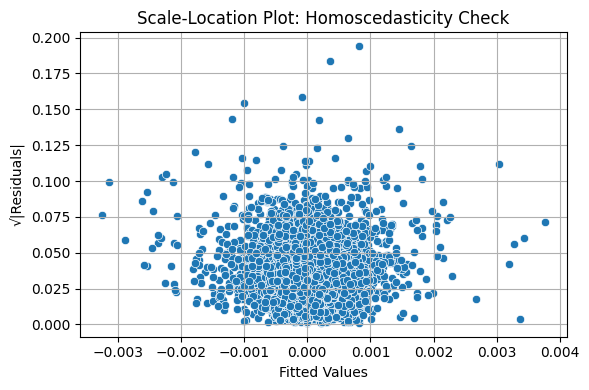

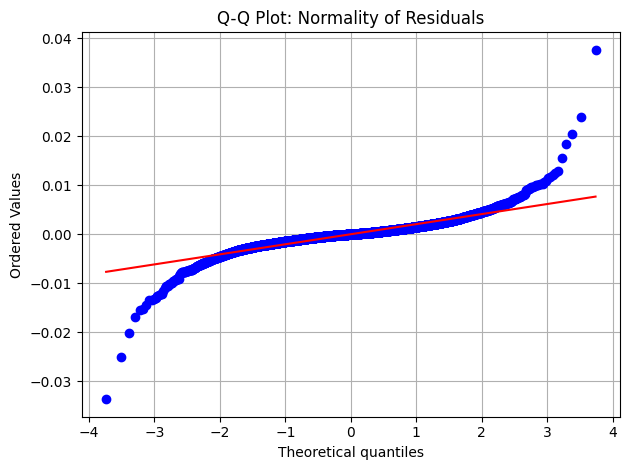

In [219]:
from statsmodels.graphics.tsaplots import plot_acf

# Regression 1 model assumptions test
# 1. Linearity: Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted: Linearity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Independence: Autocorrelation in residuals (ACF)
plot_acf(residuals, lags=30)
plt.title('Autocorrelation of Residuals')
plt.tight_layout()
plt.show()

# 3. Homoscedasticity: Residuals vs Fitted again (look for fan shape)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)))
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.title('Scale-Location Plot: Homoscedasticity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Normality: Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

From the results shown both by the graph & the model's summary, only a miniscule percent can be represented as shown by R-squared. Furthermore the residuals are only 2 observations off from the number of observations.


--- Model 2: INOD ~ NVDA_volume_diff ---
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                  0.004
Method:                       Least Squares   F-statistic:                     28.34
Date:                      Wed, 23 Jul 2025   Prob (F-statistic):           1.05e-07
Time:                              09:12:41   Log-Likelihood:                 34578.
No. Observations:                      7414   AIC:                        -6.915e+04
Df Residuals:                          7412   BIC:                        -6.914e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------

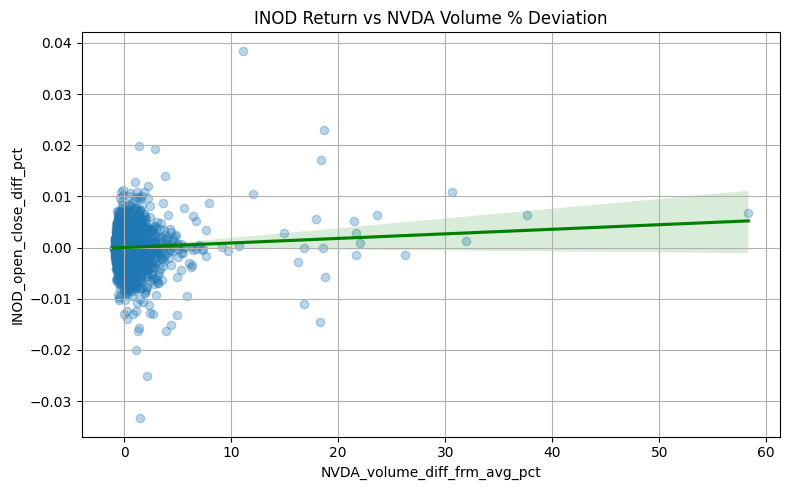

In [220]:
# Regression 2: INOD ~ NVDA volume diff
X2 = sm.add_constant(intraday_combined_df['NVDA_volume_diff_frm_avg_pct'])

model2 = sm.OLS(y1, X2).fit()

y_pred = model2.predict(X2)
residuals = y1 - y_pred

print("\n--- Model 2: INOD ~ NVDA_volume_diff ---")
print(model2.summary())
plt.figure(figsize=(8, 5))
sns.regplot(
    x='NVDA_volume_diff_frm_avg_pct',
    y='INOD_open_close_diff_pct',
    data=intraday_combined_df,
    line_kws={"color": "green"},
    scatter_kws={"alpha": 0.3}
)
plt.title('INOD Return vs NVDA Volume % Deviation')
plt.xlabel('NVDA_volume_diff_frm_avg_pct')
plt.ylabel('INOD_open_close_diff_pct')
plt.grid(True)
plt.tight_layout()
plt.show()

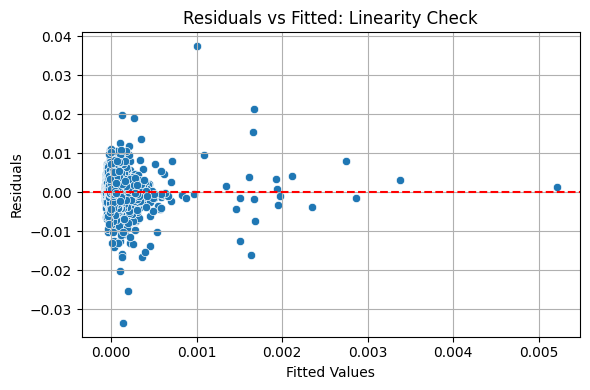

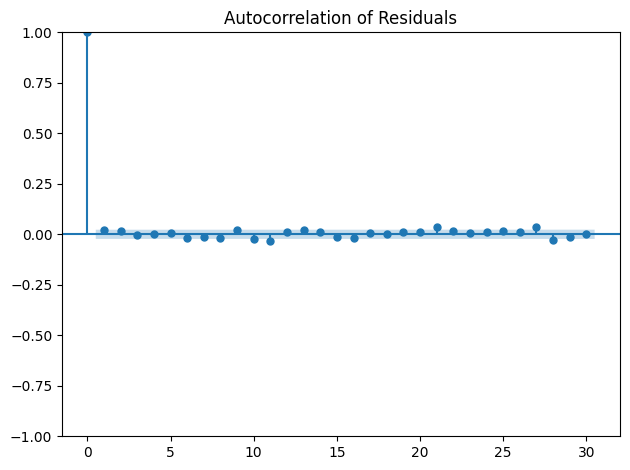

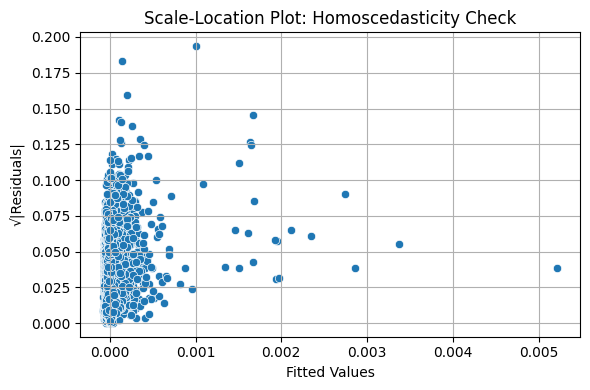

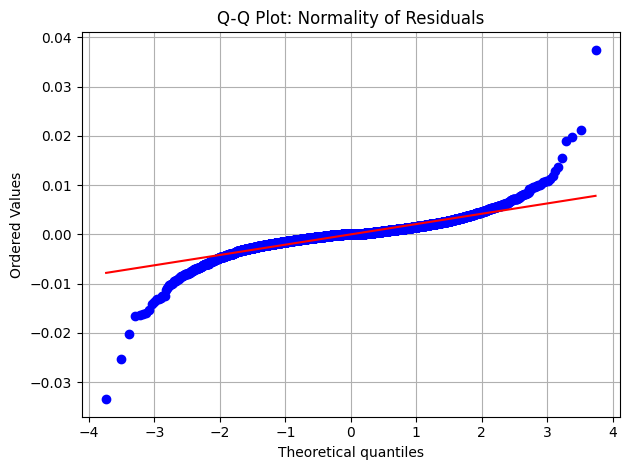

In [221]:
# Regression 2 model assumptions test
# 1. Linearity: Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted: Linearity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Independence: Autocorrelation in residuals (ACF)
plot_acf(residuals, lags=30)
plt.title('Autocorrelation of Residuals')
plt.tight_layout()
plt.show()

# 3. Homoscedasticity: Residuals vs Fitted again (look for fan shape)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)))
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.title('Scale-Location Plot: Homoscedasticity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Normality: Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

In a similar sense, the exact number of residuals showed up again, along with the Beta being unreadable from a normal perspective.

=> Ultimately, we cannot accept the results made by the 2 regression models shown above with the 2 indepedent variables of Volume & Difference between the minutes. Further reasons are due to the violation in the model assumptions. For Regression 1, the problem lies in the normality assumption, however with our cause to understand the 2 equities better, it is needed for us to keep the outliers. For Regression 2, the problems lie the assumptions of Linearity, Normality, Homoscedasticity.

In [222]:
intraday_combined_df.columns

Index(['Date', 'Time', 'Hour', 'Minute', 'Weekday', 'NVDA_Open', 'NVDA_Close',
       'NVDA_open_close_diff', 'NVDA_open_close_diff_pct', 'NVDA_High',
       'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_Volume', 'NVDA_volume_diff_frm_avg',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_Open', 'INOD_Close',
       'INOD_open_close_diff', 'INOD_open_close_diff_pct', 'INOD_High',
       'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
       'INOD_Volume', 'INOD_volume_diff_frm_avg',
       'INOD_volume_diff_frm_avg_pct', 'MRVL_Open', 'MRVL_Close',
       'MRVL_open_close_diff', 'MRVL_open_close_diff_pct', 'MRVL_High',
       'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_Volume', 'MRVL_volume_diff_frm_avg',
       'MRVL_volume_diff_frm_avg_pct', 'INOD_up', 'NVDA_up', 'MRVL_up',
       'NVDA_volume_spike', 'rth_segment'],
      dtype='object')

Multivariate Regression:


=== Multivariate Regression Results ===
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.041
Model:                                  OLS   Adj. R-squared:                  0.041
Method:                       Least Squares   F-statistic:                     157.6
Date:                      Wed, 23 Jul 2025   Prob (F-statistic):           8.94e-68
Time:                              09:12:42   Log-Likelihood:                 34718.
No. Observations:                      7414   AIC:                        -6.943e+04
Df Residuals:                          7411   BIC:                        -6.941e+04
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------

Text(0.5, 1.0, 'Residuals vs Fitted')

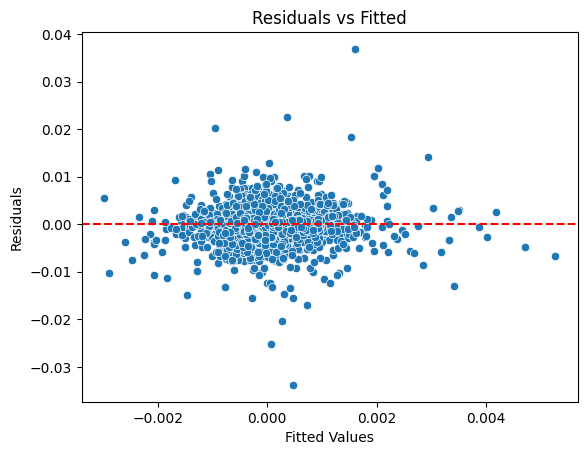

In [223]:
X_multivariate = intraday_combined_df[['NVDA_open_close_diff_pct', 'NVDA_volume_diff_frm_avg']]
X_multivariate = sm.add_constant(X_multivariate)
y1 = intraday_combined_df['INOD_open_close_diff_pct']
model_multivariate = sm.OLS(y1, X_multivariate).fit()

y_pred = model_multivariate.predict(X_multivariate)
residuals = y1 - y_pred

print("\n=== Multivariate Regression Results ===")
print(model_multivariate.summary())

adjusted_r_squared = model_multivariate.rsquared_adj
print(f"\nAdjusted R² (Multivariate): {adjusted_r_squared:.6f}")


residuals = model_multivariate.resid
fitted = model_multivariate.predict(X_multivariate)

sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')

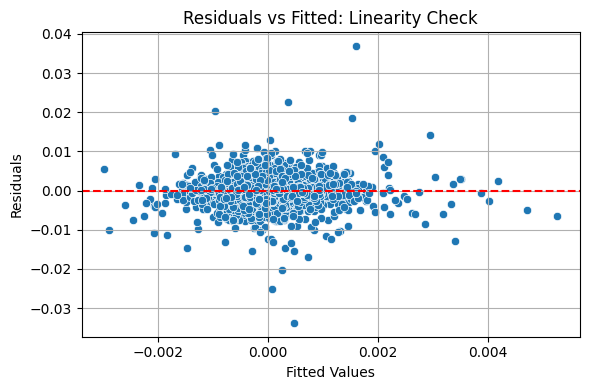

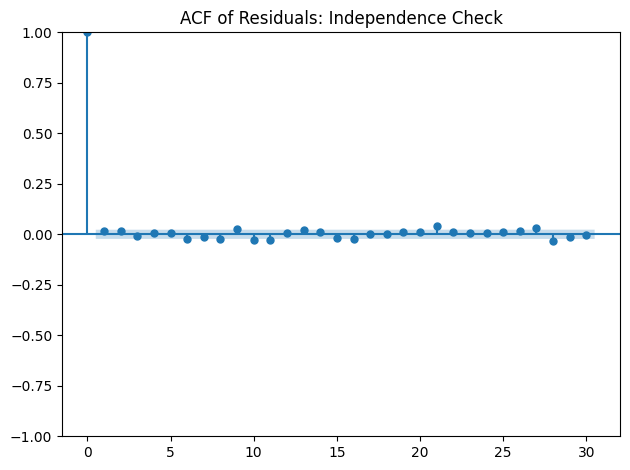

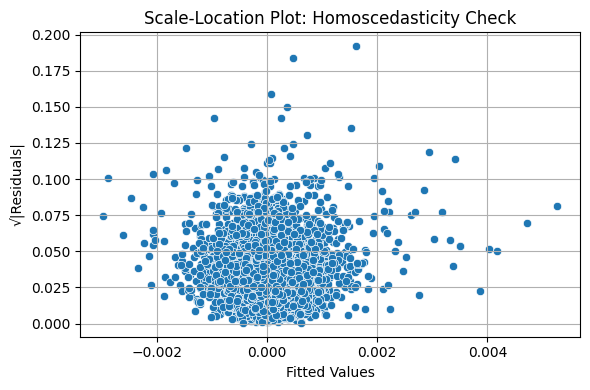

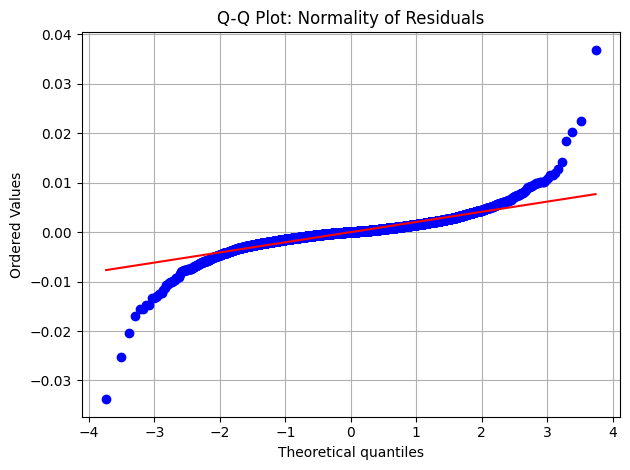


=== Variance Inflation Factor (VIF) ===
                    feature       VIF
0                     const  1.000285
1  NVDA_open_close_diff_pct  1.003737
2  NVDA_volume_diff_frm_avg  1.003737


In [224]:
# Multivariate Regression model assumptions test
# 1. Linearity: Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted: Linearity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Independence: Autocorrelation in residuals (ACF)
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals: Independence Check')
plt.tight_layout()
plt.show()

# 3. Homoscedasticity: Residuals vs Fitted again (look for fan shape)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)))
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.title('Scale-Location Plot: Homoscedasticity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Normality: Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Multicollinearity: VIF (only makes sense if >1 predictor, but we’ll still show)
vif_df = pd.DataFrame()
vif_df["feature"] = X_multivariate.columns
vif_df["VIF"] = [variance_inflation_factor(X_multivariate.values, i) for i in range(X_multivariate.shape[1])]
print("\n=== Variance Inflation Factor (VIF) ===")
print(vif_df)

In a similar fashion to the prior 2 regression model, this model yielded minimal results in what we can interpret.

=> Even with a model that considers both the value of volume and changes in price, the results that were given shown minimal results.

Interaction Term Regression


=== Interaction Term Regression Results ===
                               OLS Regression Results                               
Dep. Variable:     INOD_open_close_diff_pct   R-squared:                       0.041
Model:                                  OLS   Adj. R-squared:                  0.041
Method:                       Least Squares   F-statistic:                     106.9
Date:                      Wed, 23 Jul 2025   Prob (F-statistic):           9.99e-68
Time:                              09:12:42   Log-Likelihood:                 34721.
No. Observations:                      7414   AIC:                        -6.943e+04
Df Residuals:                          7410   BIC:                        -6.941e+04
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
------

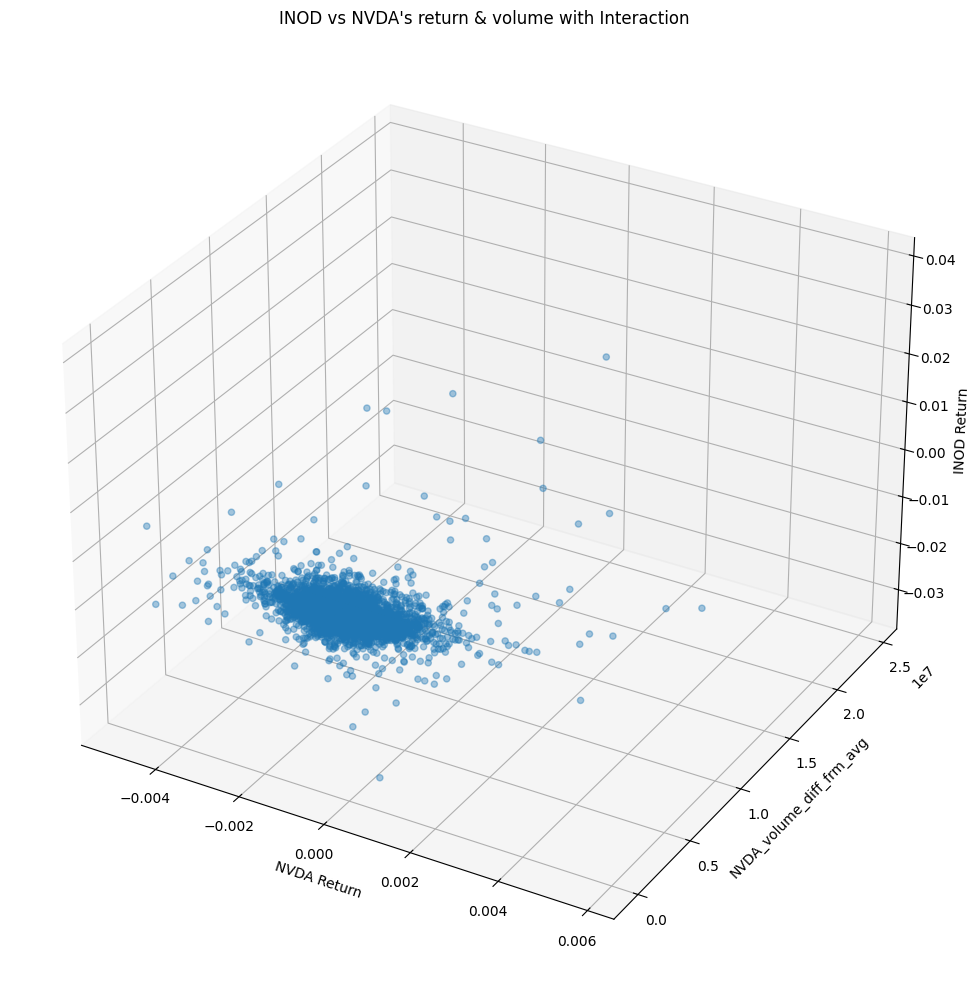

In [225]:
intraday_combined_df['interaction_NVDA_return_volume'] = (intraday_combined_df['NVDA_open_close_diff_pct'] *
    intraday_combined_df['NVDA_volume_diff_frm_avg'])

X_interaction = intraday_combined_df[[
    'NVDA_open_close_diff_pct',
    'NVDA_volume_diff_frm_avg',
    'interaction_NVDA_return_volume'
]]

X_interaction = sm.add_constant(X_interaction)
model_interaction = sm.OLS(y1, X_interaction).fit()

y_pred = model_interaction.predict(X_interaction)
residuals = y1 - y_pred

print("\n=== Interaction Term Regression Results ===")
print(model_interaction.summary())

adjusted_r2_interaction = model_interaction.rsquared_adj
print(f"\nAdjusted R² (Interaction Term Model): {adjusted_r2_interaction:.6f}")

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    intraday_combined_df['NVDA_open_close_diff_pct'],
    intraday_combined_df['NVDA_volume_diff_frm_avg'],
    y1, alpha=0.4
)
ax.set_xlabel('NVDA Return')
ax.set_ylabel('NVDA_volume_diff_frm_avg')
ax.set_zlabel('INOD Return')
plt.title('INOD vs NVDA\'s return & volume with Interaction')
plt.tight_layout()
plt.show()

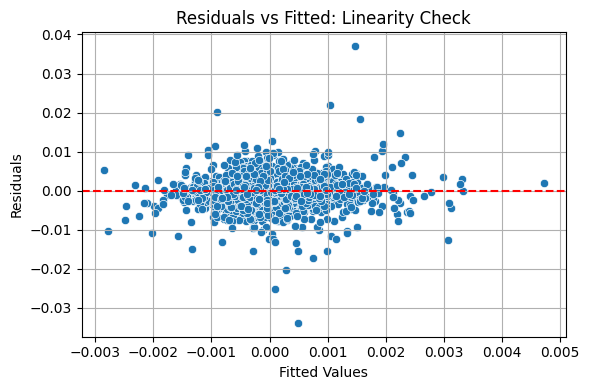

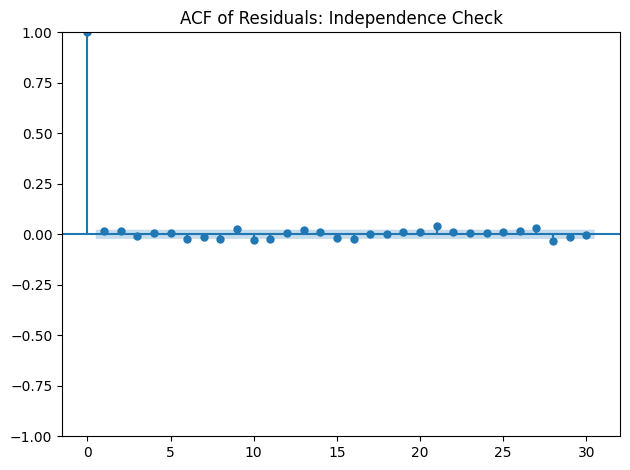

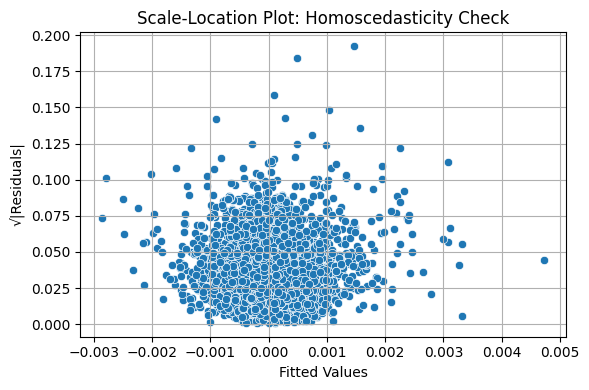

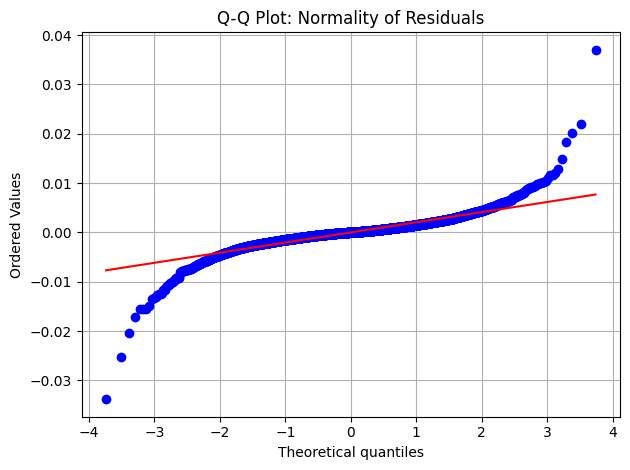


=== Variance Inflation Factor (VIF) ===
                          feature       VIF
0                           const  1.000492
1        NVDA_open_close_diff_pct  1.203109
2        NVDA_volume_diff_frm_avg  1.051473
3  interaction_NVDA_return_volume  1.259013


In [226]:
# Interaction Term model assumptions test
# 1. Linearity: Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted: Linearity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Independence: Autocorrelation in residuals (ACF)

plot_acf(residuals, lags=30)
plt.title('ACF of Residuals: Independence Check')
plt.tight_layout()
plt.show()

# 3. Homoscedasticity: Residuals vs Fitted again (look for fan shape)
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_pred, y=np.sqrt(np.abs(residuals)))
plt.xlabel('Fitted Values')
plt.ylabel('√|Residuals|')
plt.title('Scale-Location Plot: Homoscedasticity Check')
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Normality: Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Normality of Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()


# 5. Multicollinearity: VIF (only makes sense if >1 predictor, but we’ll still show)
vif_df = pd.DataFrame()
vif_df["feature"] = X_interaction.columns
vif_df["VIF"] = [variance_inflation_factor(X_interaction.values, i) for i in range(X_interaction.shape[1])]
print("\n=== Variance Inflation Factor (VIF) ===")
print(vif_df)

Conditional Probality & Bayes' Theorem:

P(INOD_up | NVDA_volume_spike): 1.0
Bayesian P(INOD_up | NVDA_volume_spike): 1.0


Text(0, 0.5, 'Frequency')

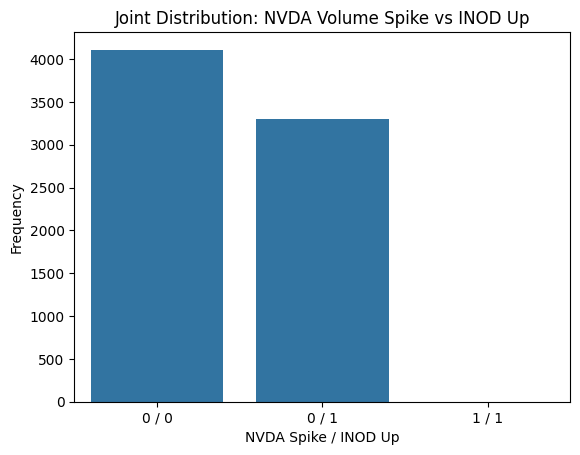

In [227]:
p_b = intraday_combined_df['NVDA_volume_spike'].sum() / len(intraday_combined_df)

joint_event = ((intraday_combined_df['NVDA_volume_spike'] == 1) & (intraday_combined_df['INOD_up'] == 1)).sum()

p_a_and_b = joint_event/ len(intraday_combined_df)

p_a_given_b = p_a_and_b / p_b

print("P(INOD_up | NVDA_volume_spike):", p_a_given_b)


# Bayesian Probability
p_inod_up = intraday_combined_df['INOD_up'].sum() / len(intraday_combined_df)

p_nvda_spike_given_inod_up = intraday_combined_df[intraday_combined_df['INOD_up'] == 1]['NVDA_volume_spike'].sum() / intraday_combined_df['INOD_up'].sum()

bayes_result = (p_nvda_spike_given_inod_up * p_inod_up) / p_b
print("Bayesian P(INOD_up | NVDA_volume_spike):", bayes_result)

event_counts = intraday_combined_df.groupby(['NVDA_volume_spike', 'INOD_up']).size().reset_index(name='count')
event_counts['label'] = event_counts['NVDA_volume_spike'].astype(str) + " / " + event_counts['INOD_up'].astype(str)

event_counts = intraday_combined_df.groupby(['NVDA_volume_spike', 'INOD_up']).size().reset_index(name='count')
event_counts['label'] = event_counts['NVDA_volume_spike'].astype(str) + " / " + event_counts['INOD_up'].astype(str)

sns.barplot(data=event_counts, x='label', y='count')
plt.title('Joint Distribution: NVDA Volume Spike vs INOD Up')
plt.xlabel('NVDA Spike / INOD Up')
plt.ylabel('Frequency')

- No 1 / 0 bar exists — meaning there is no case where NVDA spiked but INOD did not go up.
- 0 / 0 - Most common outcome — market calm or shared inactivity
- 0 / 1 - Second most common — INOD moved up independently
- 1 / 1 - Present, though frequency is low — possibly rare event

=> A confirmation of the conditional rule: whenever NVDA spikes, INOD rises.

In [228]:
"""
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# For demonstration: assuming y_pred_prob already exists
threshold = 0.5
y_pred_class = (y_pred_prob >= threshold).astype(int)
y_true = df['INOD_up']

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
"""

'\nfrom sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score\n\n# For demonstration: assuming y_pred_prob already exists\nthreshold = 0.5\ny_pred_class = (y_pred_prob >= threshold).astype(int)\ny_true = df[\'INOD_up\']\n\n# Confusion Matrix\ncm = confusion_matrix(y_true, y_pred_class)\nprint("Confusion Matrix:\n", cm)\n\n# Precision, Recall, F1\nprecision = precision_score(y_true, y_pred_class)\nrecall = recall_score(y_true, y_pred_class)\nf1 = f1_score(y_true, y_pred_class)\n\nprint(f"Precision: {precision:.4f}")\nprint(f"Recall: {recall:.4f}")\nprint(f"F1 Score: {f1:.4f}")\n'

ANOVA & ANCOVA & MANOVA & ANCOVA & Chi-Squared Test of Independence:

In [229]:
intraday_combined_df['log_INOD_return'] = np.log1p(intraday_combined_df['INOD_open_close_diff_pct'])

In [230]:
# ANOVA
from statsmodels.formula.api import ols
model_anova = ols('log_INOD_return ~ C(Weekday)', data=intraday_combined_df).fit()
anova_table = sm.stats.anova_lm(model_anova, typ=2)
print(anova_table)

              sum_sq      df         F    PR(>F)
C(Weekday)  0.000022     4.0  1.067595  0.370732
Residual    0.038732  7409.0       NaN       NaN


In [231]:
# ANCOVA
model_ancova = ols('log_INOD_return ~ C(Weekday) + NVDA_volume_diff_frm_avg_pct', data=intraday_combined_df).fit()
ancova_table = sm.stats.anova_lm(model_ancova, typ=2)
print(ancova_table)

                                sum_sq      df          F        PR(>F)
C(Weekday)                    0.000024     4.0   1.154605  3.288297e-01
NVDA_volume_diff_frm_avg_pct  0.000143     1.0  27.429433  1.674167e-07
Residual                      0.038589  7408.0        NaN           NaN


In [232]:
import scipy.stats as stats
# Crosstab
contingency_table = pd.crosstab(intraday_combined_df['INOD_up'], intraday_combined_df['NVDA_volume_spike'])
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-squared Test:")
print("Chi2 Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)

Chi-squared Test:
Chi2 Statistic: 0.011901537864813107
p-value: 0.9131277991867801
Degrees of Freedom: 1


In [233]:
# MANOVA
from statsmodels.multivariate.manova import MANOVA
manova = MANOVA.from_formula('log_INOD_return + INOD_volume_diff_frm_avg_pct ~ C(rth_segment)', data=intraday_combined_df)
print(manova.mv_test())

                   Multivariate linear model
                                                                
----------------------------------------------------------------
         Intercept        Value  Num DF   Den DF  F Value Pr > F
----------------------------------------------------------------
            Wilks' lambda 0.9923 2.0000 7408.0000 28.9150 0.0000
           Pillai's trace 0.0077 2.0000 7408.0000 28.9150 0.0000
   Hotelling-Lawley trace 0.0078 2.0000 7408.0000 28.9150 0.0000
      Roy's greatest root 0.0078 2.0000 7408.0000 28.9150 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
     C(rth_segment)     Value  Num DF   Den DF   F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.9194 8.0000 14816.0000  79.4538 0.0000
         Pillai's trace 0.0806 8.0000 14818.0

In [234]:
# MANCOVA with covariate
mancova = MANOVA.from_formula('log_INOD_return + INOD_volume_diff_frm_avg_pct ~ C(rth_segment) + NVDA_volume_diff_frm_avg_pct', data=intraday_combined_df)
print(mancova.mv_test())

                      Multivariate linear model
                                                                     
----------------------------------------------------------------------
          Intercept         Value   Num DF    Den DF   F Value  Pr > F
----------------------------------------------------------------------
             Wilks' lambda  0.9989  2.0000  7407.0000   4.0094  0.0182
            Pillai's trace  0.0011  2.0000  7407.0000   4.0094  0.0182
    Hotelling-Lawley trace  0.0011  2.0000  7407.0000   4.0094  0.0182
       Roy's greatest root  0.0011  2.0000  7407.0000   4.0094  0.0182
---------------------------------------------------------------------
                                                                     
----------------------------------------------------------------------
       C(rth_segment)      Value   Num DF    Den DF    F Value  Pr > F
----------------------------------------------------------------------
            Wilks' lambda  0.984

In [235]:
###ANOVA post hoc test - used for hypothesis testing
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_oneway = pairwise_tukeyhsd(endog = intraday_combined_df["log_INOD_return"], groups = intraday_combined_df["Weekday"], alpha = 0.05)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Friday,Monday,0.0001,0.8003,-0.0001,0.0003,False
Friday,Thursday,0.0002,0.3142,-0.0001,0.0004,False
Friday,Tuesday,0.0,0.9877,-0.0002,0.0003,False
Friday,Wednesday,0.0001,0.8522,-0.0002,0.0003,False
Monday,Thursday,0.0001,0.8618,-0.0001,0.0003,False
Monday,Tuesday,-0.0001,0.9619,-0.0003,0.0002,False
Monday,Wednesday,-0.0,1.0,-0.0002,0.0002,False
Thursday,Tuesday,-0.0001,0.5126,-0.0004,0.0001,False
Thursday,Wednesday,-0.0001,0.8579,-0.0003,0.0002,False
Tuesday,Wednesday,0.0,0.9785,-0.0002,0.0003,False


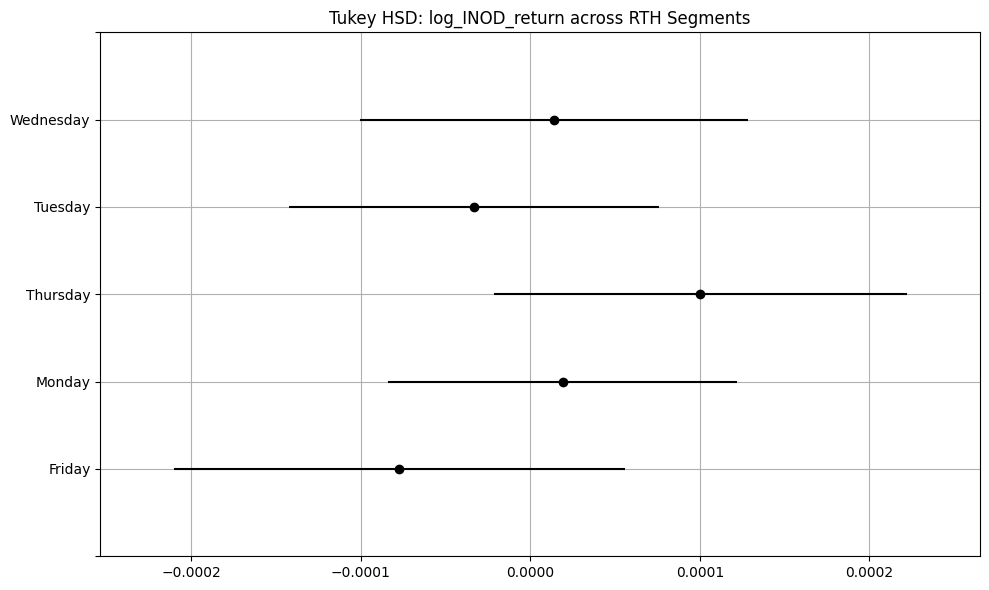

In [236]:
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(intraday_combined_df["log_INOD_return"], intraday_combined_df["Weekday"])
tukey_result = mc.tukeyhsd()
tukey_result.plot_simultaneous()
plt.title("Tukey HSD: log_INOD_return across RTH Segments")
plt.grid(True)
plt.tight_layout()
plt.show()

=> Ultimately, we cannot accept the results made by the 2 regression models shown above with the 2 indepedent variables of Volume & Difference between the minutes. Further reasons are due to the violation in the model assumptions. For Regression 1, the problem lies in the normality assumption, however with our cause to understand the 2 equities better, it is needed for us to keep the outliers. For Regression 2, the problems lie the assumptions of Linearity, Normality, Homoscedasticity.

Logistic Regression  with both sklearn(prediction) & statsmodel(inference)

Optimization terminated successfully.
         Current function value: 0.677687
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                INOD_up   No. Observations:                 7414
Model:                          Logit   Df Residuals:                     7411
Method:                           MLE   Df Model:                            2
Date:                Wed, 23 Jul 2025   Pseudo R-squ.:                 0.01392
Time:                        09:12:43   Log-Likelihood:                -5024.4
converged:                       True   LL-Null:                       -5095.3
Covariance Type:            nonrobust   LLR p-value:                 1.553e-31
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.2255      0.024     -9.551      0.000      -0.272

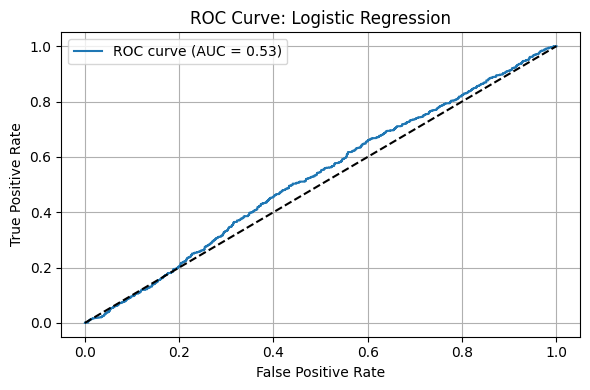

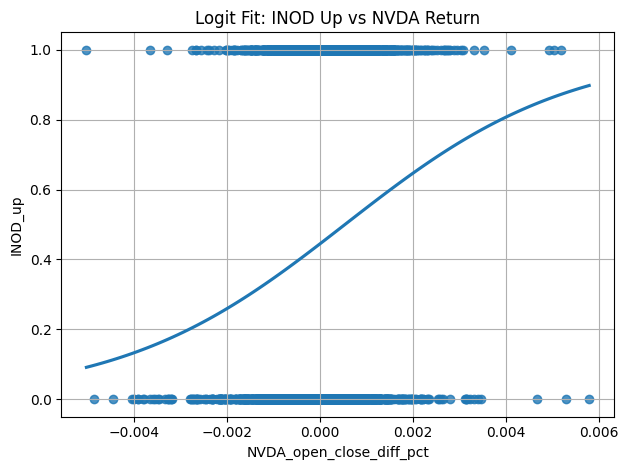

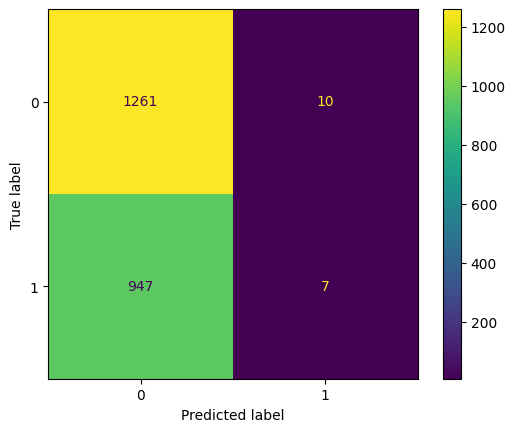

In [237]:
X_logistic = intraday_combined_df[[
    'NVDA_open_close_diff_pct',
    'NVDA_volume_diff_frm_avg',
]]
y_logistic = intraday_combined_df['INOD_up']

X_train, X_test, y_train, y_test = train_test_split(X_logistic,y_logistic, test_size=0.3, random_state=42)

# Add constant
X_logit = sm.add_constant(X_logistic)

# Fit logistic regression (inference)
model_logit = sm.Logit(y_logistic, X_logit).fit()
print(model_logit.summary())

# Optional: convert log-odds to odds ratios
odds_ratios = np.exp(model_logit.params)
print("\n=== Odds Ratios ===")
print(odds_ratios)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_logistic, y_logistic, test_size=0.3, random_state=42
)

# Fit classifier
clf = LogisticRegression().fit(X_train, y_train)

# Coefficients
print("Intercept:", clf.intercept_)
print("Coefficients:", clf.coef_)

# Predict class labels and probabilities
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Classification metrics
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Logistic Regression')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

sns.regplot(
    x='NVDA_open_close_diff_pct',
    y='INOD_up',
    data=intraday_combined_df,
    logistic=True,
    ci=None
)
plt.title("Logit Fit: INOD Up vs NVDA Return")
plt.grid(True)
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf.classes_)
disp.plot()

Give the complexity of the stock market or any market for that matter, it has been shown in this notebook and thus we cannot create a model that can predict the future of a stock given the current circumstance.

Bootstrap, CI Bands & Sampling Laws

In [238]:
x = intraday_combined_df['INOD_open_close_diff_pct']

n_iterations = 10000
sample_size = len(x)

bootstrap_means = np.array([np.random.choice(x, size=sample_size, replace=True).mean() for _ in range(n_iterations)])

lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)
mean_estimate = bootstrap_means.mean()

print(f"Bootstrap 95% CI for mean: ({lower_bound:.8f}, {upper_bound:.8f})")
print(f"Bootstrap Mean Estimate: {mean_estimate:.8f}")

Bootstrap 95% CI for mean: (-0.00004241, 0.00006119)
Bootstrap Mean Estimate: 0.00000925


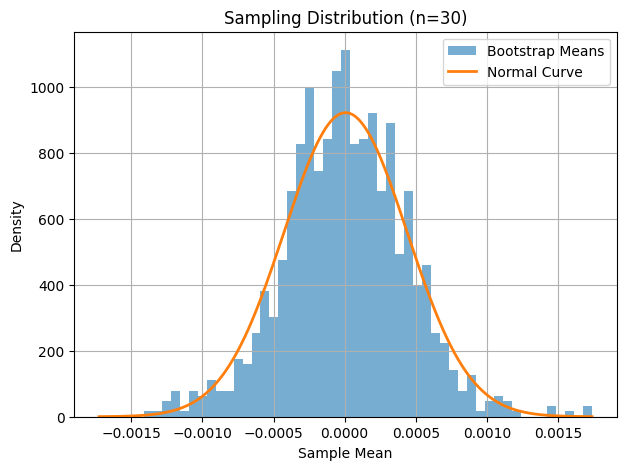

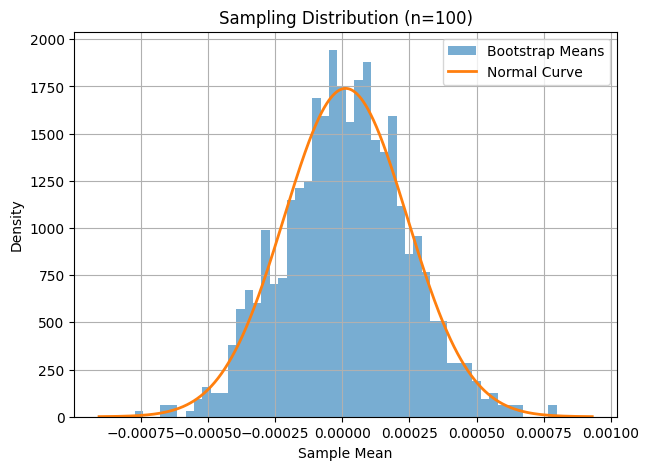

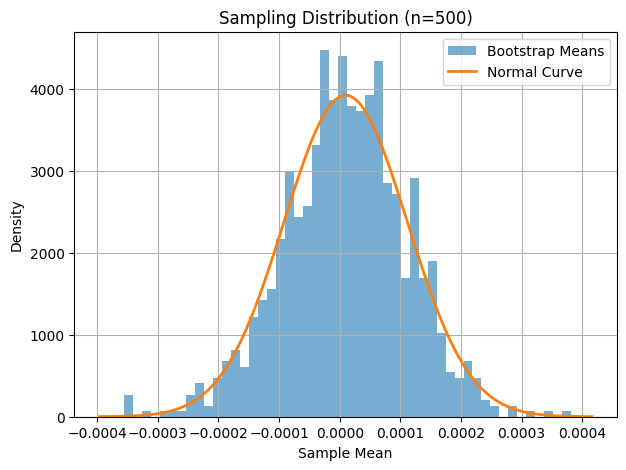

In [239]:
from scipy.stats import norm

def plot_sampling_distribution(sample_sizes, original_data, n_resamples=1000):
    for size in sample_sizes:
        sample_means = [
            np.random.choice(original_data, size=size, replace=True).mean()
            for _ in range(n_resamples)
        ]
        mu = np.mean(sample_means)
        sigma = np.std(sample_means)
        
        # Plot histogram
        plt.figure(figsize=(7, 5))
        plt.hist(sample_means, bins=50, density=True, alpha=0.6, label='Bootstrap Means')
        
        # Overlay normal curve
        x_vals = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
        plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), linewidth=2, label='Normal Curve')
        
        plt.title(f'Sampling Distribution (n={size})')
        plt.xlabel('Sample Mean')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()

# Run for increasing sizes
plot_sampling_distribution(
    sample_sizes=[30, 100, 500],
    original_data=x
)

In [240]:
intraday_combined_df.columns

Index(['Date', 'Time', 'Hour', 'Minute', 'Weekday', 'NVDA_Open', 'NVDA_Close',
       'NVDA_open_close_diff', 'NVDA_open_close_diff_pct', 'NVDA_High',
       'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_Volume', 'NVDA_volume_diff_frm_avg',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_Open', 'INOD_Close',
       'INOD_open_close_diff', 'INOD_open_close_diff_pct', 'INOD_High',
       'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
       'INOD_Volume', 'INOD_volume_diff_frm_avg',
       'INOD_volume_diff_frm_avg_pct', 'MRVL_Open', 'MRVL_Close',
       'MRVL_open_close_diff', 'MRVL_open_close_diff_pct', 'MRVL_High',
       'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_Volume', 'MRVL_volume_diff_frm_avg',
       'MRVL_volume_diff_frm_avg_pct', 'INOD_up', 'NVDA_up', 'MRVL_up',
       'NVDA_volume_spike', 'rth_segment', 'interaction_NVDA_return_volume',
       'log_INOD_return'],
      dtype='obj

Rolling Correlation (Residuals or Raw Returns)

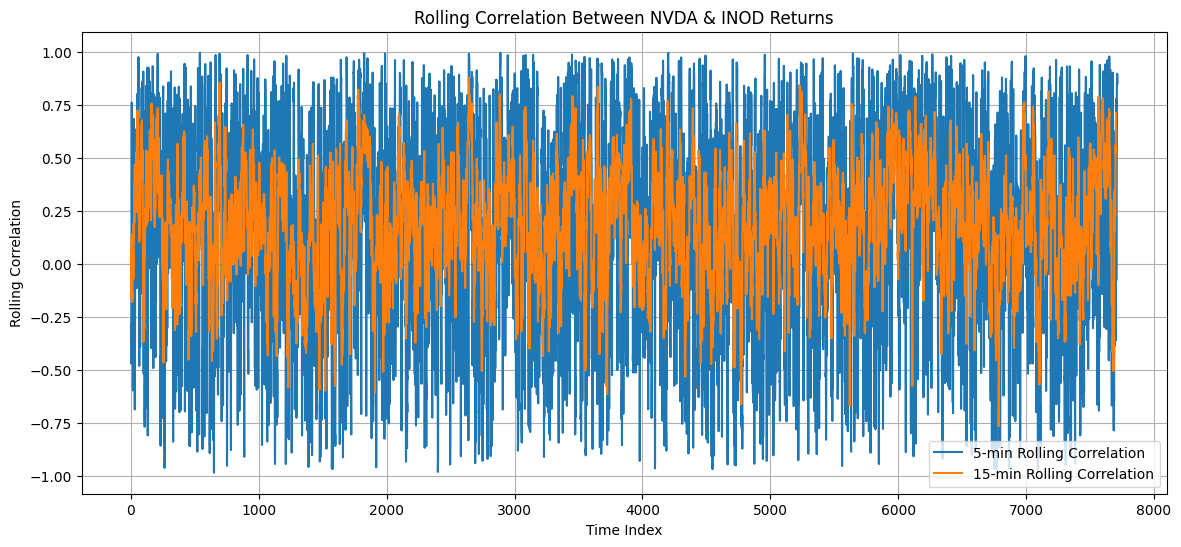

In [241]:
intraday_combined_df['rolling_corr_5min'] = intraday_combined_df['NVDA_open_close_diff_pct'].rolling(window=5).corr(
    intraday_combined_df['INOD_open_close_diff_pct'])

intraday_combined_df['rolling_corr_15min'] = intraday_combined_df['NVDA_open_close_diff_pct'].rolling(window=15).corr(
    intraday_combined_df['INOD_open_close_diff_pct'])

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(intraday_combined_df['rolling_corr_5min'], label='5-min Rolling Correlation')
plt.plot(intraday_combined_df['rolling_corr_15min'], label='15-min Rolling Correlation')
plt.title("Rolling Correlation Between NVDA & INOD Returns")
plt.xlabel("Time Index")
plt.ylabel("Rolling Correlation")
plt.legend()
plt.grid(True)
plt.show()

Granger Causality Test

In [242]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare the relevant dataframe (drop NaNs, align)
granger_df = intraday_combined_df[[
    'INOD_open_close_diff_pct',
    'NVDA_open_close_diff_pct',
    'NVDA_volume_diff_frm_avg_pct'
]].dropna()

# The Granger causality test expects a 2D array with [y, x]
print("\n=== Granger Causality Test: NVDA Return → INOD Return ===")
grangercausalitytests(granger_df[['INOD_open_close_diff_pct', 'NVDA_open_close_diff_pct']], maxlag=5)

print("\n=== Granger Causality Test: NVDA Volume → INOD Return ===")
grangercausalitytests(granger_df[['INOD_open_close_diff_pct', 'NVDA_volume_diff_frm_avg_pct']], maxlag=5)


=== Granger Causality Test: NVDA Return → INOD Return ===

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3205  , p=0.5713  , df_denom=7410, df_num=1
ssr based chi2 test:   chi2=0.3206  , p=0.5712  , df=1
likelihood ratio test: chi2=0.3206  , p=0.5712  , df=1
parameter F test:         F=0.3205  , p=0.5713  , df_denom=7410, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2044  , p=0.8151  , df_denom=7407, df_num=2
ssr based chi2 test:   chi2=0.4091  , p=0.8150  , df=2
likelihood ratio test: chi2=0.4091  , p=0.8150  , df=2
parameter F test:         F=0.2044  , p=0.8151  , df_denom=7407, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1264  , p=0.3369  , df_denom=7404, df_num=3
ssr based chi2 test:   chi2=3.3824  , p=0.3363  , df=3
likelihood ratio test: chi2=3.3816  , p=0.3364  , df=3
parameter F test:         F=1.1264  , p=0.3369  , df_denom=7404, df_num=3

Granger Causality
number of 

{np.int64(1): ({'ssr_ftest': (np.float64(1.6477062273711878),
    np.float64(0.19931155203947734),
    np.float64(7410.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(1.6483733149126336),
    np.float64(0.1991804762959768),
    np.int64(1)),
   'lrtest': (np.float64(1.6481900738726836),
    np.float64(0.19920545082311958),
    np.int64(1)),
   'params_ftest': (np.float64(1.6477062273760974),
    np.float64(0.19931155203907974),
    np.float64(7410.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.5593977111443824),
    np.float64(0.21033169321366083),
    np.float64(7407.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.1209007249904586),
    np.float64(0.2100414551027713),
    np.int64(2)),
   'lrtest': (np.float64(3.1202438652981073),
    np.float64(0.2101104503149845),
    np.int64(2)),
   'params_ftest': (np.float64(1.5593977111436268),
    np.float64(0.21033169321386785),
    np.float64(7407.0),
    2.0)},
   array([[0., 0., 1., 0., 0.

ML

In [243]:
intraday_combined_df.columns

Index(['Date', 'Time', 'Hour', 'Minute', 'Weekday', 'NVDA_Open', 'NVDA_Close',
       'NVDA_open_close_diff', 'NVDA_open_close_diff_pct', 'NVDA_High',
       'NVDA_Low', 'NVDA_high_low_diff', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_Volume', 'NVDA_volume_diff_frm_avg',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_Open', 'INOD_Close',
       'INOD_open_close_diff', 'INOD_open_close_diff_pct', 'INOD_High',
       'INOD_Low', 'INOD_high_low_diff', 'INOD_high_low_diff_pct_frm_close',
       'INOD_Volume', 'INOD_volume_diff_frm_avg',
       'INOD_volume_diff_frm_avg_pct', 'MRVL_Open', 'MRVL_Close',
       'MRVL_open_close_diff', 'MRVL_open_close_diff_pct', 'MRVL_High',
       'MRVL_Low', 'MRVL_high_low_diff', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_Volume', 'MRVL_volume_diff_frm_avg',
       'MRVL_volume_diff_frm_avg_pct', 'INOD_up', 'NVDA_up', 'MRVL_up',
       'NVDA_volume_spike', 'rth_segment', 'interaction_NVDA_return_volume',
       'log_INOD_return', 'rolling_corr_5mi

In [244]:
features_to_scale = [
    'NVDA_open_close_diff_pct',
    'NVDA_high_low_diff_pct_frm_close',
    'NVDA_volume_diff_frm_avg_pct',
    'INOD_volume_diff_frm_avg_pct',
    'MRVL_open_close_diff_pct',
    'MRVL_high_low_diff_pct_frm_close',
    'MRVL_volume_diff_frm_avg_pct',
    'interaction_NVDA_return_volume',
    'rolling_corr_5min',
    'rolling_corr_15min'
]


X_raw = intraday_combined_df[features_to_scale].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

X_scaled.shape


# One-hot encode
weekday_dummies = pd.get_dummies(intraday_combined_df['Weekday'], prefix='weekday')
segment_dummies = pd.get_dummies(intraday_combined_df['rth_segment'], prefix='rth')

# Combine all
X_encoded = pd.concat([
    pd.DataFrame(X_scaled, columns=features_to_scale).reset_index(drop=True),
    weekday_dummies.reset_index(drop=True),
    segment_dummies.reset_index(drop=True)
], axis=1)

X_encoded = X_encoded.dropna()

In [245]:
## try out KMeans clustering with k=3
# Fit model
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_encoded)

# Store results
cluster_labels = kmeans.labels_
inertia_k = kmeans.inertia_
sil_score_k = silhouette_score(X_encoded, cluster_labels)

print(f"Cluster Inertia (k=3): {inertia_k}")
print(f"Silhouette Score (k=3): {sil_score_k:.4f}")

Cluster Inertia (k=3): 75318.57166415949
Silhouette Score (k=3): 0.5240


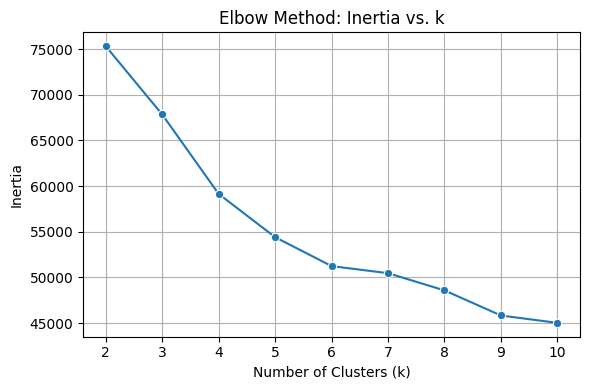

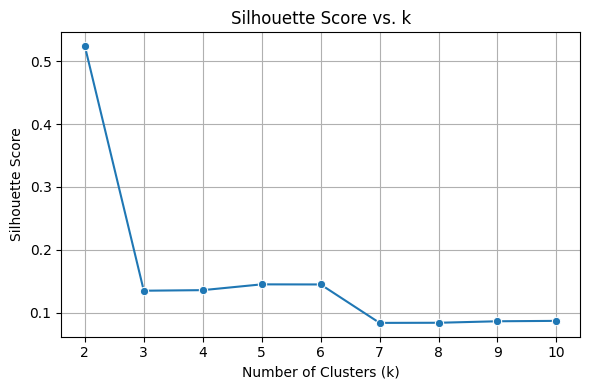

In [246]:
num_clusters = list(range(2, 11))
inertia_list = []
silhouette_list = []

for k in num_clusters:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_encoded)
    inertia_list.append(model.inertia_)
    silhouette_list.append(silhouette_score(X_encoded, labels))

# Plot Inertia
plt.figure(figsize=(6, 4))
sns.lineplot(x=num_clusters, y=inertia_list, marker='o')
plt.title("Elbow Method: Inertia vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Silhouette
plt.figure(figsize=(6, 4))
sns.lineplot(x=num_clusters, y=silhouette_list, marker='o')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [247]:
features_updated = X_encoded.columns.tolist()

X_clustered = pd.DataFrame(X_encoded, columns=features_updated)
X_clustered['cluster'] = cluster_labels

intraday_combined_df = intraday_combined_df.dropna(axis=0)
# Add back to main DataFrame
intraday_combined_df['market_cluster'] = cluster_labels


X_clustered.columns

C:\Users\Admin\AppData\Local\Temp\ipykernel_11736\521937122.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intraday_combined_df['market_cluster'] = cluster_labels


Index(['NVDA_open_close_diff_pct', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_volume_diff_frm_avg_pct',
       'MRVL_open_close_diff_pct', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_volume_diff_frm_avg_pct', 'interaction_NVDA_return_volume',
       'rolling_corr_5min', 'rolling_corr_15min', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'rth_Afternoon Run', 'rth_Closing Rush',
       'rth_Midday Lull', 'rth_Morning Trend', 'rth_Opening Bell', 'cluster'],
      dtype='object')

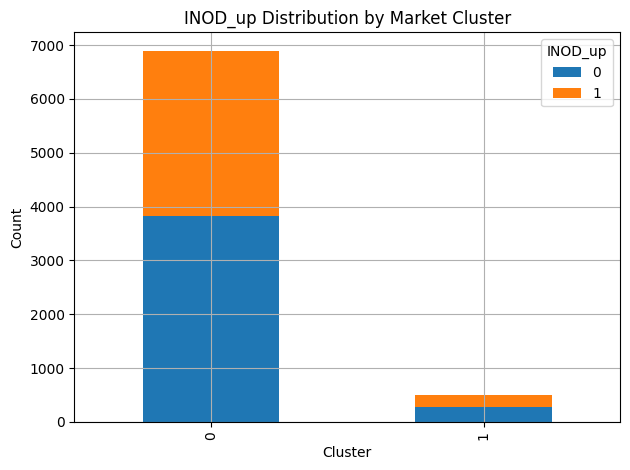


INOD_up Rate per Cluster:
market_cluster
0    0.445509
1    0.456522
Name: INOD_up, dtype: float64


In [248]:
cluster_counts = intraday_combined_df.groupby('market_cluster')['INOD_up'].value_counts().unstack().fillna(0)
cluster_counts.plot(kind='bar', stacked=True)
plt.title("INOD_up Distribution by Market Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title='INOD_up', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


cluster_rate = intraday_combined_df.groupby('market_cluster')['INOD_up'].mean()
print("\nINOD_up Rate per Cluster:")
print(cluster_rate)


=== Naive Bayes Classification Report ===
Accuracy:  0.5505
Precision: 0.5128
Recall:    0.1195
F1 Score:  0.1939


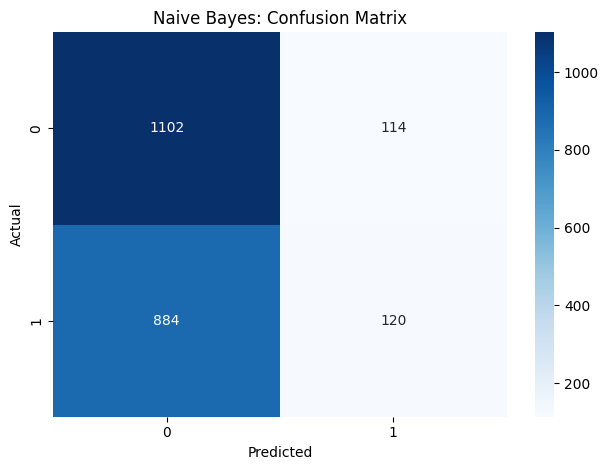

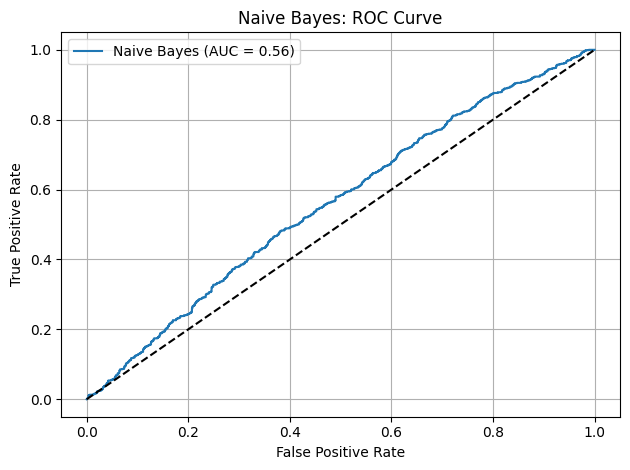

In [249]:
# Naive Bayes Classifier
X_train, X_test, y_train, y_test = train_test_split(X_clustered, intraday_combined_df['INOD_up'], test_size=0.3, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)
y_proba_nb = nb.predict_proba(X_test)[:, 1]

print("\n=== Naive Bayes Classification Report ===")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_nb):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_nb):.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes: Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba_nb)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes: ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== With market_cluster Feature ===
              precision    recall  f1-score   support

           0       0.56      0.91      0.69      1216
           1       0.52      0.12      0.20      1004

    accuracy                           0.55      2220
   macro avg       0.54      0.51      0.44      2220
weighted avg       0.54      0.55      0.47      2220

AUC Score: 0.5600


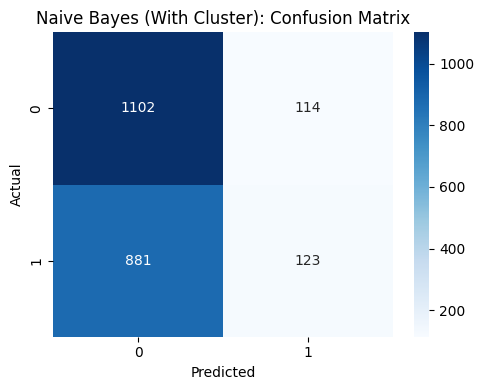

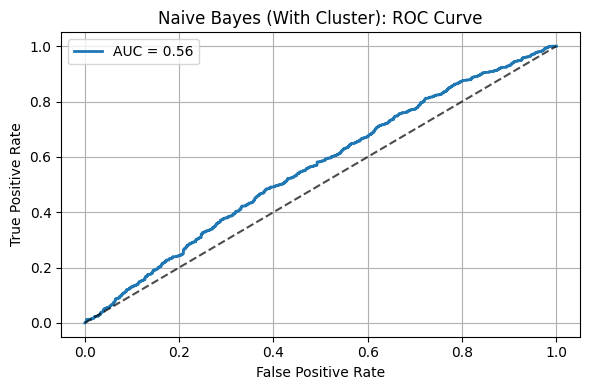

In [250]:
cluster_dummies = pd.get_dummies(intraday_combined_df['market_cluster'], prefix='cluster')
features_updated = X_clustered.columns.tolist()
# Combine with original scaled features
X_combined = pd.concat([
    pd.DataFrame(X_clustered, columns=features_updated).reset_index(drop=True),
    cluster_dummies.reset_index(drop=True)
], axis=1)

X_combined = X_combined.drop(columns=['cluster'], axis=1)

y = intraday_combined_df['INOD_up']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Fit Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predict
y_pred = nb.predict(X_test)
y_proba = nb.predict_proba(X_test)[:, 1]

print("\n=== With market_cluster Feature ===")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Naive Bayes (With Cluster): Confusion Matrix')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes (With Cluster): ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The recall on 1 which means INOD is going up can be explained by the unexplanable nature of a stocks and its unique correlation with the market's sentiments. even with the add on feature of cluster and encoding all categorical data, it is still in limbo.

In [254]:
intraday_combined_df.columns
print(X_combined.columns)
print(X_clustered.columns)
print(X_encoded.columns)

Index(['NVDA_open_close_diff_pct', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_volume_diff_frm_avg_pct',
       'MRVL_open_close_diff_pct', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_volume_diff_frm_avg_pct', 'interaction_NVDA_return_volume',
       'rolling_corr_5min', 'rolling_corr_15min', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_Wednesday', 'weekday_Thursday',
       'weekday_Friday', 'rth_Afternoon Run', 'rth_Closing Rush',
       'rth_Midday Lull', 'rth_Morning Trend', 'rth_Opening Bell', 'cluster_0',
       'cluster_1'],
      dtype='object')
Index(['NVDA_open_close_diff_pct', 'NVDA_high_low_diff_pct_frm_close',
       'NVDA_volume_diff_frm_avg_pct', 'INOD_volume_diff_frm_avg_pct',
       'MRVL_open_close_diff_pct', 'MRVL_high_low_diff_pct_frm_close',
       'MRVL_volume_diff_frm_avg_pct', 'interaction_NVDA_return_volume',
       'rolling_corr_5min', 'rolling_corr_15min', 'weekday_Monday',
       'weekday_Tuesday', 'weekday_W

=== Decision Tree Classifier ===
              precision    recall  f1-score   support

           0       0.60      0.90      0.72      1216
           1       0.69      0.26      0.37      1004

    accuracy                           0.61      2220
   macro avg       0.64      0.58      0.55      2220
weighted avg       0.64      0.61      0.56      2220

Confusion Matrix:
 [[1098  118]
 [ 747  257]]


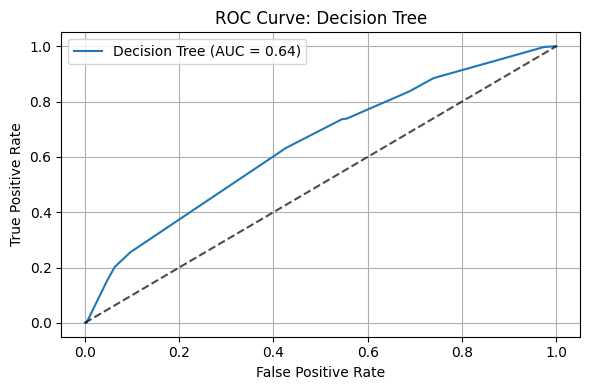

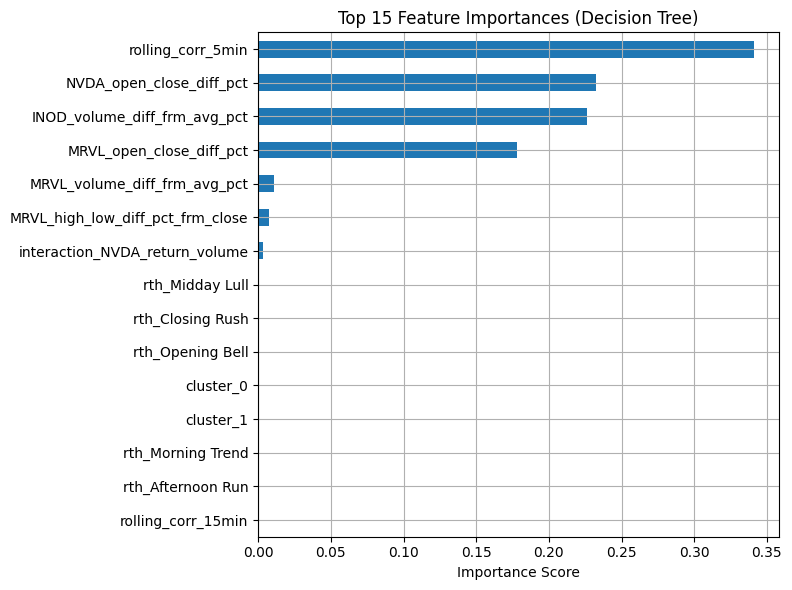

In [252]:
X = X_combined
y = intraday_combined_df['INOD_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=4, random_state=42)  # start with shallow tree
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)
y_proba = dtree.predict_proba(X_test)[:, 1]

print("=== Decision Tree Classifier ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Decision Tree")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


importances = pd.Series(dtree.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
importances.tail(15).plot(kind='barh')
plt.title('Top 15 Feature Importances (Decision Tree)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.grid(True)
plt.show()

It is like gambling, roulette even. But the 15 minute rolling correlation decides a lot as INOD is both a reflector and reactor of NVDA & the AI market as a whole.

Fitting 5 folds for each of 66 candidates, totalling 330 fits



=== Best Random Forest Parameters ===
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}

=== Random Forest Classification Report ===
              precision    recall  f1-score   support

           0       0.62      0.79      0.70      1216
           1       0.62      0.43      0.51      1004

    accuracy                           0.62      2220
   macro avg       0.62      0.61      0.60      2220
weighted avg       0.62      0.62      0.61      2220

Confusion Matrix:
 [[956 260]
 [577 427]]


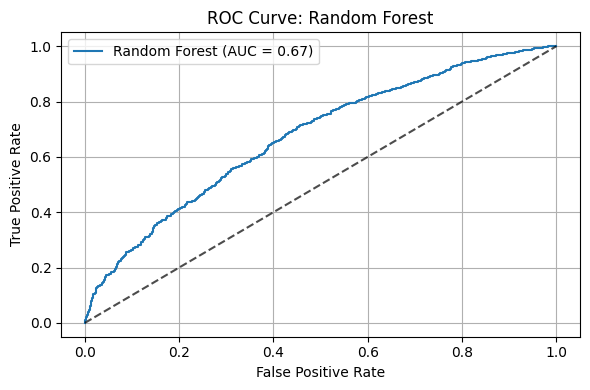

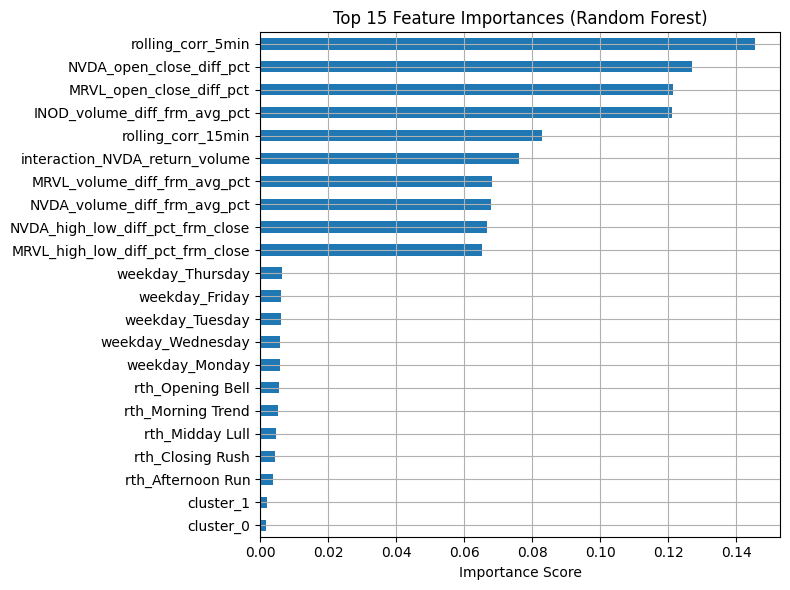

In [253]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7, 10, 20, 30, 40, 50, 75, 100, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("\n=== Best Random Forest Parameters ===")
print(grid_search.best_params_)

# Predict
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Report
print("\n=== Random Forest Classification Report ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rf_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
rf_importances = rf_importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
rf_importances.tail(30).plot(kind='barh')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.grid(True)
plt.show()


Fitting 5 folds for each of 32 candidates, totalling 160 fits


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:22:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Best XGBoost Parameters ===
{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}

=== XGBoost Classification Report ===
              precision    recall  f1-score   support

           0       0.63      0.82      0.71      1229
           1       0.65      0.41      0.50       991

    accuracy                           0.64      2220
   macro avg       0.64      0.62      0.61      2220
weighted avg       0.64      0.64      0.62      2220



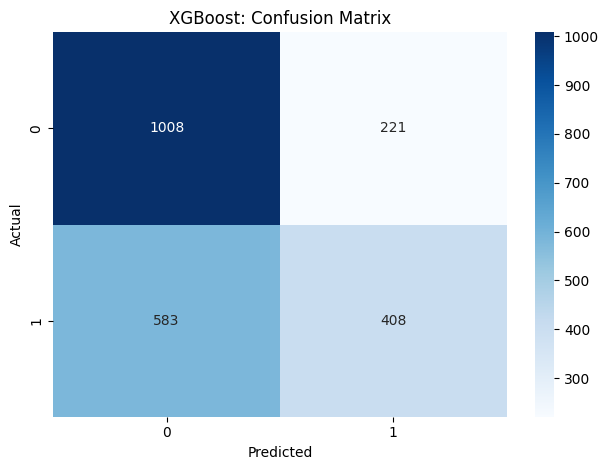

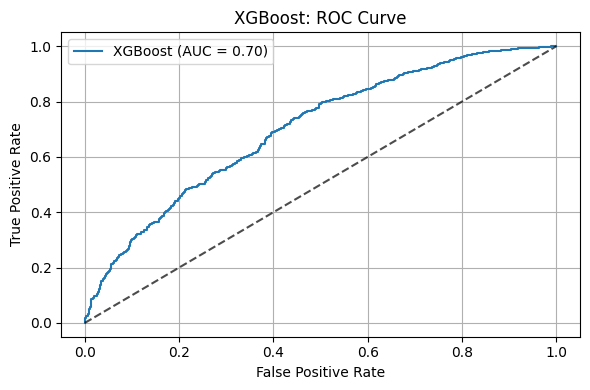

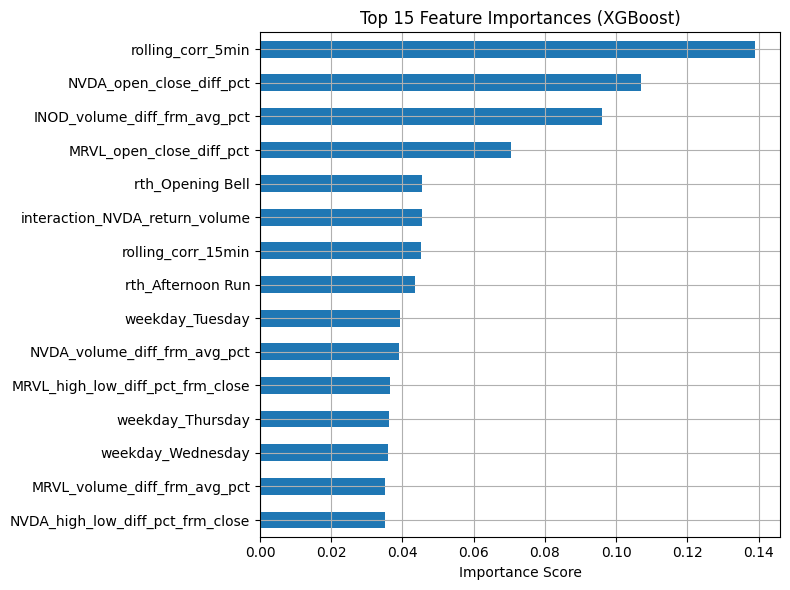

In [258]:
# XGBoost Classifier
X = X_combined
y = intraday_combined_df['INOD_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6, 10, 20],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_xgb = grid_search.best_estimator_
print("\n=== Best XGBoost Parameters ===")
print(grid_search.best_params_)

y_pred = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost Classification Report ===")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost: Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost: ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

xgb_importances = pd.Series(best_xgb.feature_importances_, index=X.columns)
xgb_importances = xgb_importances.sort_values(ascending=True)

plt.figure(figsize=(8, 6))
xgb_importances.tail(15).plot(kind='barh')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.grid(True)
plt.show()